<a href="https://colab.research.google.com/github/rtegao/M5Forecasting/blob/master/FeatureEngineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [0]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler

# Functions

In [0]:
def normalizing_data(df_train,df_val,df_test):
  try:
    data_list = [df_train.copy(),df_val.copy(),df_test.copy()]
    min_list = df_train.min(axis=0)
    max_list = df_train.max(axis=0)
    for j in range(len(data_list)):
      for i in range(df_train.shape[1]):
        data_list[j].iloc[:,i] = (data_list[j].iloc[:,i]-min_list[i])/abs((min_list[i]-max_list[i]))
      data_list[j]=data_list[j].values
  except:
    df_train = df_train.values.reshape(-1,1)
    df_val = df_val.values.reshape(-1,1)
    df_test = df_test.values.reshape(-1,1)

    data_list = [df_train.copy(),df_val.copy(),df_test.copy()]
    min_list = df_train.min(axis=0)
    max_list = df_train.max(axis=0)
    for j in range(3):
      for i in range(df_train.shape[1]):
        data_list[j][:,i] = (data_list[j][:,i]-min_list[i])/abs((min_list[i]-max_list[i]))
        # data_list[j] = (data_list[j]-min_list)/abs((min_list-max_list))

  df_train_norm = data_list[0].copy()
  df_val_norm = data_list[1].copy()
  df_test_norm = data_list[2].copy()

  print(df_train_norm.max(axis=0))
  print(df_train_norm.min(axis=0))
  print('\n')

  print(df_val_norm.max(axis=0))
  print(df_val_norm.min(axis=0))
  print('\n')

  print(df_test_norm.max(axis=0))
  print(df_test_norm.min(axis=0))

  print('-------------------------')

  print(df_train_norm.shape)
  print(df_val_norm.shape)
  print(df_test_norm.shape)
  return df_train_norm,df_val_norm,df_test_norm

In [0]:
def Regressor(future_steps,time_steps,n_features,df_train,df_val,df_test):
  # future_steps: how many days in the furure to predict 
  # time_steps: number of samples the LSTM model will use for predict 28 days in the future
  # n_features: number of features (LSTM input) 

  #################### TRAIN #################################################
  # Defining the number of samples for the train data
  n_samples = df_train.shape[0]
  x_train = []
  y_train = []

  # shaping data to have the number of time_steps in the x_train ans the 28 future values in the y_train 
  for i in range(time_steps,n_samples - time_steps): 
    x_train.append(df_train[i - time_steps : i, :]) 
    y_train.append(df_train[i : i+future_steps,-1]) 

  x_train,y_train = np.array(x_train),np.array(y_train) # transforming in array
  # LSTM need 3D tensor as input 
  x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],n_features))  

  ##################### VALIDATION ###############################################

  # to predict the first 28 values of the validation data, LSTM need time_steps values. 
  # to make this possible I'm using the last 60 values that came before the validation data.
  df_val = np.concatenate((df_train[-time_steps:],df_val))

  n_samples = df_val.shape[0]
  x_val = []
  y_val = []

  for i in range(time_steps,n_samples - time_steps):
    x_val.append(df_val[i - time_steps : i, :]) 
    y_val.append(df_val[i : i+future_steps,-1]) 

  x_val,y_val = np.array(x_val),np.array(y_val)
  x_val = np.reshape(x_val,(x_val.shape[0],x_val.shape[1],n_features))

  ####################### TEST ################################################
  # the same methodologie implemented in training and validation data are here in the test data

  df_test = np.concatenate((df_val[-time_steps:],df_test))
  n_samples = df_test.shape[0]
  x_test = []
  y_test = []

  for i in range(time_steps,n_samples - time_steps):
    x_test.append(df_test[i - time_steps : i, :]) 
    y_test.append(df_test[i : i+future_steps,-1]) 

  x_test,y_test = np.array(x_test),np.array(y_test)
  x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],n_features))

  x_train = x_train.astype(np.float32)
  y_train = y_train.astype(np.float32)

  x_val = x_val.astype(np.float32)
  y_val = y_val.astype(np.float32)

  x_test = x_test.astype(np.float32)
  y_test = y_test.astype(np.float32)
  
  return x_train,x_test,x_val,y_train,y_val,y_test

# Reading Datasets

In [0]:
# Contains information about the dates the products are sold.
df_calendar = pd.read_csv('/content/drive/My Drive/Specialization/Projects/Recurrent Neural Networks/M5 - Data/calendar.csv')

# Contains information about the price of the products sold per store and date.
df_price = pd.read_csv('/content/drive/My Drive/Specialization/Projects/Recurrent Neural Networks/M5 - Data/sell_prices.csv')

#Contains the historical daily unit sales data per product and store.
df_sales = pd.read_csv('/content/drive/My Drive/Specialization/Projects/Recurrent Neural Networks/M5 - Data/sales_train_validation.csv')

In [0]:
df_calendar

date  wm_yr_wk    weekday  ...  snap_CA  snap_TX  snap_WI
0     2011-01-29     11101   Saturday  ...        0        0        0
1     2011-01-30     11101     Sunday  ...        0        0        0
2     2011-01-31     11101     Monday  ...        0        0        0
3     2011-02-01     11101    Tuesday  ...        1        1        0
4     2011-02-02     11101  Wednesday  ...        1        0        1
...          ...       ...        ...  ...      ...      ...      ...
1964  2016-06-15     11620  Wednesday  ...        0        1        1
1965  2016-06-16     11620   Thursday  ...        0        0        0
1966  2016-06-17     11620     Friday  ...        0        0        0
1967  2016-06-18     11621   Saturday  ...        0        0        0
1968  2016-06-19     11621     Sunday  ...        0        0        0

[1969 rows x 14 columns]

In [0]:
df_price

store_id        item_id  wm_yr_wk  sell_price
0           CA_1  HOBBIES_1_001     11325        9.58
1           CA_1  HOBBIES_1_001     11326        9.58
2           CA_1  HOBBIES_1_001     11327        8.26
3           CA_1  HOBBIES_1_001     11328        8.26
4           CA_1  HOBBIES_1_001     11329        8.26
...          ...            ...       ...         ...
6841116     WI_3    FOODS_3_827     11617        1.00
6841117     WI_3    FOODS_3_827     11618        1.00
6841118     WI_3    FOODS_3_827     11619        1.00
6841119     WI_3    FOODS_3_827     11620        1.00
6841120     WI_3    FOODS_3_827     11621        1.00

[6841121 rows x 4 columns]

In [0]:
df_sales

id        item_id  ... d_1912 d_1913
0      HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  ...      1      1
1      HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  ...      0      0
2      HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  ...      1      1
3      HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  ...      7      2
4      HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  ...      2      4
...                              ...            ...  ...    ...    ...
30485    FOODS_3_823_WI_3_validation    FOODS_3_823  ...      0      1
30486    FOODS_3_824_WI_3_validation    FOODS_3_824  ...      1      0
30487    FOODS_3_825_WI_3_validation    FOODS_3_825  ...      1      0
30488    FOODS_3_826_WI_3_validation    FOODS_3_826  ...      1      3
30489    FOODS_3_827_WI_3_validation    FOODS_3_827  ...      0      0

[30490 rows x 1919 columns]

# Filtering a Specific Product

In [0]:
df_food =  df_sales.iloc[df_sales[df_sales['id'] == 'FOODS_3_495_WI_3_validation'].loc[:,'d_1':].index[0],6:]

# Joing DataFrames

In [0]:
df_calendar_price = df_calendar.set_index('wm_yr_wk').join(df_price[(df_price['store_id'] == df_sales[df_sales['id'] == 'FOODS_3_495_WI_3_validation']['store_id'].values[0]) & 
         (df_price['item_id'] == df_sales[df_sales['id'] == 'FOODS_3_495_WI_3_validation']['item_id'].values[0])].set_index('wm_yr_wk')).reset_index()
df_final = df_food.to_frame('qty_sales').reset_index().set_index('index').join(df_calendar_price.set_index('d'))

In [0]:
df_final

qty_sales  wm_yr_wk        date  ... store_id      item_id  sell_price
index                                   ...                                  
d_1            1     11101  2011-01-29  ...     WI_3  FOODS_3_495        1.77
d_2            2     11101  2011-01-30  ...     WI_3  FOODS_3_495        1.77
d_3            4     11101  2011-01-31  ...     WI_3  FOODS_3_495        1.77
d_4            2     11101  2011-02-01  ...     WI_3  FOODS_3_495        1.77
d_5            3     11101  2011-02-02  ...     WI_3  FOODS_3_495        1.77
...          ...       ...         ...  ...      ...          ...         ...
d_1909         1     11612  2016-04-20  ...     WI_3  FOODS_3_495        1.98
d_1910         2     11612  2016-04-21  ...     WI_3  FOODS_3_495        1.98
d_1911         4     11612  2016-04-22  ...     WI_3  FOODS_3_495        1.98
d_1912         2     11613  2016-04-23  ...     WI_3  FOODS_3_495        1.98
d_1913         0     11613  2016-04-24  ...     WI_3  FOODS_3_495        1.98

[1913 rows x 17 columns]

# Genereting New Features

- ## Revenue
- ## Lag Day
- ## Roling Mean Revenue/Sales

In [0]:
df_final['revenue_day'] = df_final['sell_price']*df_final['qty_sales']

In [0]:
df_final['lag_1'] = df_final['qty_sales'].shift(1)
df_final['lag_2'] = df_final['qty_sales'].shift(2)
df_final['lag_3'] = df_final['qty_sales'].shift(3)
df_final['lag_4'] = df_final['qty_sales'].shift(4)
df_final['lag_5'] = df_final['qty_sales'].shift(5)
df_final['lag_6'] = df_final['qty_sales'].shift(6)
df_final['lag_7'] = df_final['qty_sales'].shift(7)

In [0]:
df_final['rolling_mean_revenue_2'] = df_final['revenue_day'].rolling(window = 2).mean()
df_final['rolling_mean_revenue_3'] = df_final['revenue_day'].rolling(window = 3).mean()
df_final['rolling_mean_revenue_4'] = df_final['revenue_day'].rolling(window = 4).mean()
df_final['rolling_mean_revenue_5'] = df_final['revenue_day'].rolling(window = 5).mean()
df_final['rolling_mean_revenue_6'] = df_final['revenue_day'].rolling(window = 6).mean()
df_final['rolling_mean_revenue_7'] = df_final['revenue_day'].rolling(window = 7).mean()

In [0]:
df_final['rolling_mean_sales_2'] = df_final['qty_sales'].rolling(window = 2).mean()
df_final['rolling_mean_sales_3'] = df_final['qty_sales'].rolling(window = 3).mean()
df_final['rolling_mean_sales_4'] = df_final['qty_sales'].rolling(window = 4).mean()
df_final['rolling_mean_sales_5'] = df_final['qty_sales'].rolling(window = 5).mean()
df_final['rolling_mean_sales_6'] = df_final['qty_sales'].rolling(window = 6).mean()
df_final['rolling_mean_sales_7'] = df_final['qty_sales'].rolling(window = 7).mean()

In [0]:
df_final = df_final[['wday','month','sell_price','revenue_day','lag_1','lag_2','lag_3','lag_4','lag_5','lag_6','lag_7','rolling_mean_revenue_2',	'rolling_mean_revenue_3',	'rolling_mean_revenue_4',	'rolling_mean_revenue_5',	'rolling_mean_revenue_6',	'rolling_mean_revenue_7',
                     'rolling_mean_sales_2',	'rolling_mean_sales_3',	'rolling_mean_sales_4',	'rolling_mean_sales_5',	'rolling_mean_sales_6',	'rolling_mean_sales_7', 'qty_sales']].fillna(0).astype(float)

In [0]:
df_final

wday  month  ...  rolling_mean_sales_7  qty_sales
index                ...                                 
d_1      1.0    1.0  ...              0.000000        1.0
d_2      2.0    1.0  ...              0.000000        2.0
d_3      3.0    1.0  ...              0.000000        4.0
d_4      4.0    2.0  ...              0.000000        2.0
d_5      5.0    2.0  ...              0.000000        3.0
...      ...    ...  ...                   ...        ...
d_1909   5.0    4.0  ...              2.857143        1.0
d_1910   6.0    4.0  ...              2.571429        2.0
d_1911   7.0    4.0  ...              2.714286        4.0
d_1912   1.0    4.0  ...              2.857143        2.0
d_1913   2.0    4.0  ...              2.285714        0.0

[1913 rows x 24 columns]

In [0]:
df_final.corr()

wday     month  ...  rolling_mean_sales_7  qty_sales
wday                    1.000000 -0.000771  ...              0.001277  -0.085983
month                  -0.000771  1.000000  ...             -0.111900  -0.063398
sell_price             -0.000212  0.189916  ...             -0.088644  -0.070568
revenue_day            -0.086179 -0.058242  ...              0.485518   0.999454
lag_1                  -0.063276 -0.060799  ...              0.501442   0.154693
lag_2                  -0.012181 -0.062983  ...              0.503140   0.109199
lag_3                   0.036394 -0.060608  ...              0.526606   0.168682
lag_4                   0.092493 -0.057803  ...              0.506556   0.088127
lag_5                   0.085384 -0.057354  ...              0.507587   0.109259
lag_6                  -0.043217 -0.053459  ...              0.500921   0.128097
lag_7                  -0.086534 -0.045136  ...              0.245610   0.084568
rolling_mean_revenue_2 -0.098609 -0.074820  ...              0.649215   0.759145
rolling_mean_revenue_3 -0.082230 -0.087155  ...              0.760629   0.644159
rolling_mean_revenue_4 -0.051899 -0.093741  ...              0.844626   0.597827
rolling_mean_revenue_5 -0.011178 -0.098414  ...              0.906599   0.543864
rolling_mean_revenue_6  0.016853 -0.101950  ...              0.957814   0.511707
rolling_mean_revenue_7  0.001431 -0.102774  ...              0.998449   0.486419
rolling_mean_sales_2   -0.097961 -0.081466  ...              0.650194   0.759781
rolling_mean_sales_3   -0.081787 -0.094718  ...              0.761570   0.644780
rolling_mean_sales_4   -0.051433 -0.101845  ...              0.845623   0.598260
rolling_mean_sales_5   -0.010929 -0.106990  ...              0.907729   0.544332
rolling_mean_sales_6    0.016821 -0.110872  ...              0.959010   0.512285
rolling_mean_sales_7    0.001277 -0.111900  ...              1.000000   0.486284
qty_sales              -0.085983 -0.063398  ...              0.486284   1.000000

[24 rows x 24 columns]

# Using All Features

##Spliting Data

In [0]:
train_limit = int(round((df_final.shape[0])*0.7,0))
val_limit = int(round((df_final.shape[0])*0.85,0))

df_train = df_final[:train_limit]
df_val = df_final[train_limit:val_limit]
df_test = df_final[val_limit:]

print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

(1339, 24)
(287, 24)
(287, 24)


## Normalizing

In [0]:
df_train_norm,df_val_norm,df_test_norm = normalizing_data(df_train,df_val,df_test)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


[1.         1.         1.         0.8        0.8        0.8
 0.8        0.8        0.8        0.8        0.8        0.8
 1.         0.96428571 0.82857143 0.84210526 0.74468085 0.8
 1.         0.96428571 0.82857143 0.84210526 0.74468085 0.8       ]
[0.         0.         1.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.02857143 0.05263158 0.08510638 0.
 0.         0.         0.02857143 0.05263158 0.08510638 0.        ]


[1.         1.         1.         0.66666667 0.66666667 0.66666667
 0.66666667 0.66666667 0.66666667 0.66666667 0.66666667 0.65
 0.73913043 0.78571429 0.71428571 0.76315789 0.68085106 0.65
 0.73913043 0.78571429 0.71428571 0.76315789 0.68085106 0.66666667]
[0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.0000

## Preprocessing

In [0]:
time_steps = 84
future_steps = 28
n_features = df_train_norm.shape[1]
x_train,x_test,x_val,y_train,y_val,y_test = Regressor(future_steps = future_steps,time_steps = time_steps,n_features = n_features,df_train = df_train_norm,df_val = df_val_norm,df_test = df_test_norm)

## LSTM

---

###Using the model that performed better at the FOODS_3_495_WI_3.ipynb notebook. 

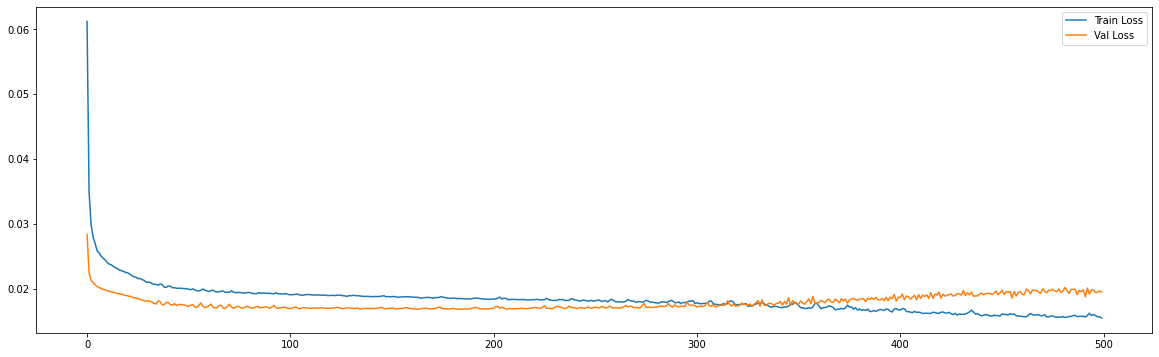

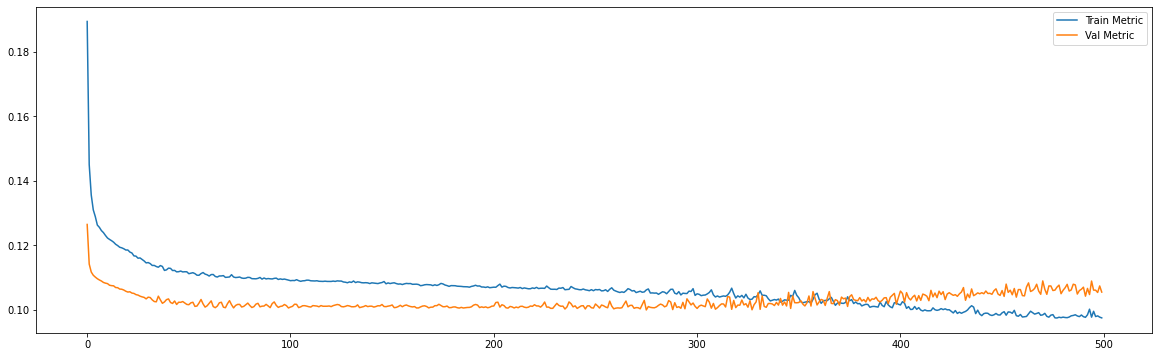



37/37 [==============================] - 0s 8ms/step - loss: 0.0151 - mae: 0.0950
loss and metric train data [0.015051762573421001, 0.09500505775213242]
7/7 [==============================] - 0s 7ms/step - loss: 0.0195 - mae: 0.1055
loss and metric val data [0.01946280337870121, 0.10551487654447556]
7/7 [==============================] - 0s 7ms/step - loss: 0.0217 - mae: 0.1163
loss and metric test data [0.021683407947421074, 0.1162734106183052]


In [0]:
regressor = Sequential()
regressor.add(LSTM(units=50, return_sequences=False, input_shape=(time_steps, n_features))) 
regressor.add(Dropout(0.2))
regressor.add(Dense(units=future_steps))

#Compiling the LSTM
adam = optimizers.Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999, decay = 0.0)
regressor.compile(optimizer = adam, loss = 'mse', metrics=['mae'])

#Fitting to traning set
history = regressor.fit(x_train, y_train, validation_data=(x_val,y_val), 
                        epochs = 500, batch_size=100, verbose = 0, shuffle= False)

plt.figure(figsize=(20,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train Loss', 'Val Loss'])

plt.figure(figsize=(20,6))
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.legend(['Train Metric', 'Val Metric'])
plt.show()

print('\n')
print('loss and metric train data',regressor.evaluate(x_train,y_train))
print('loss and metric val data',regressor.evaluate(x_val,y_val))
print('loss and metric test data',regressor.evaluate(x_test,y_test))

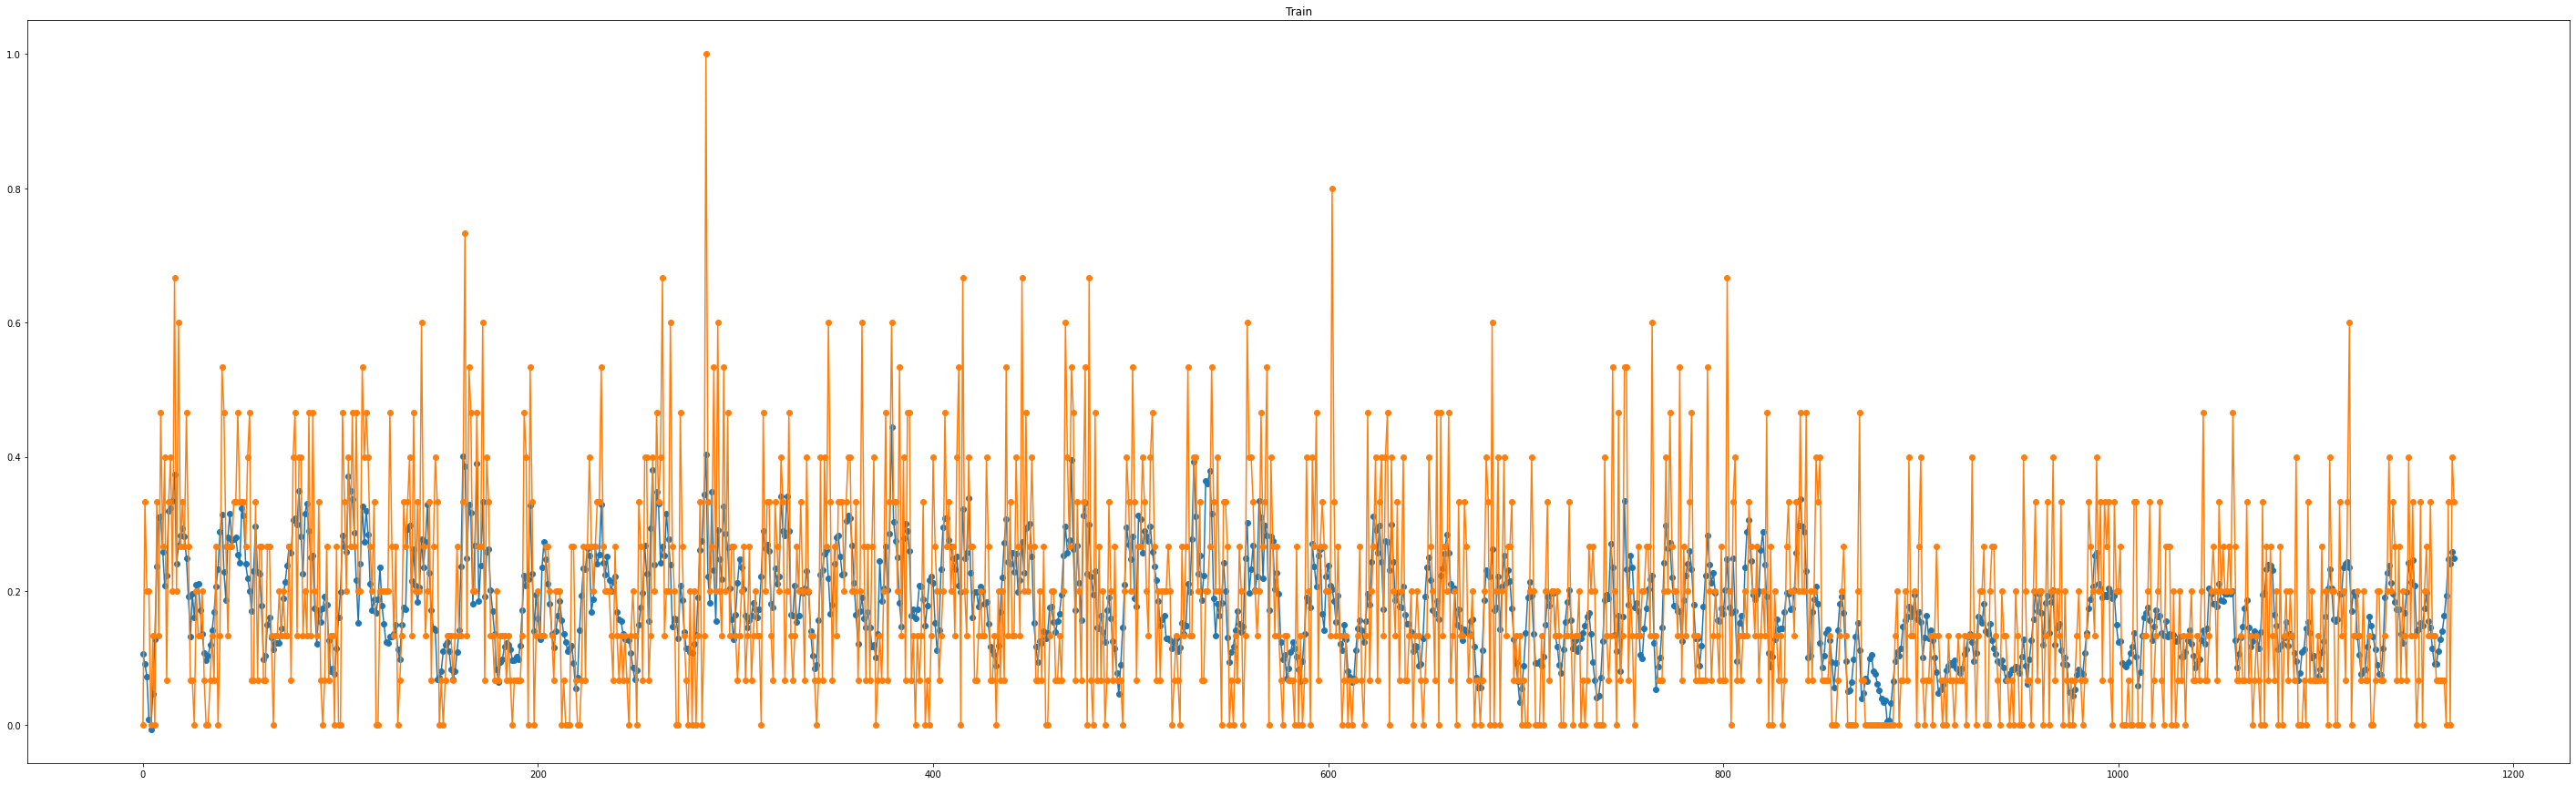

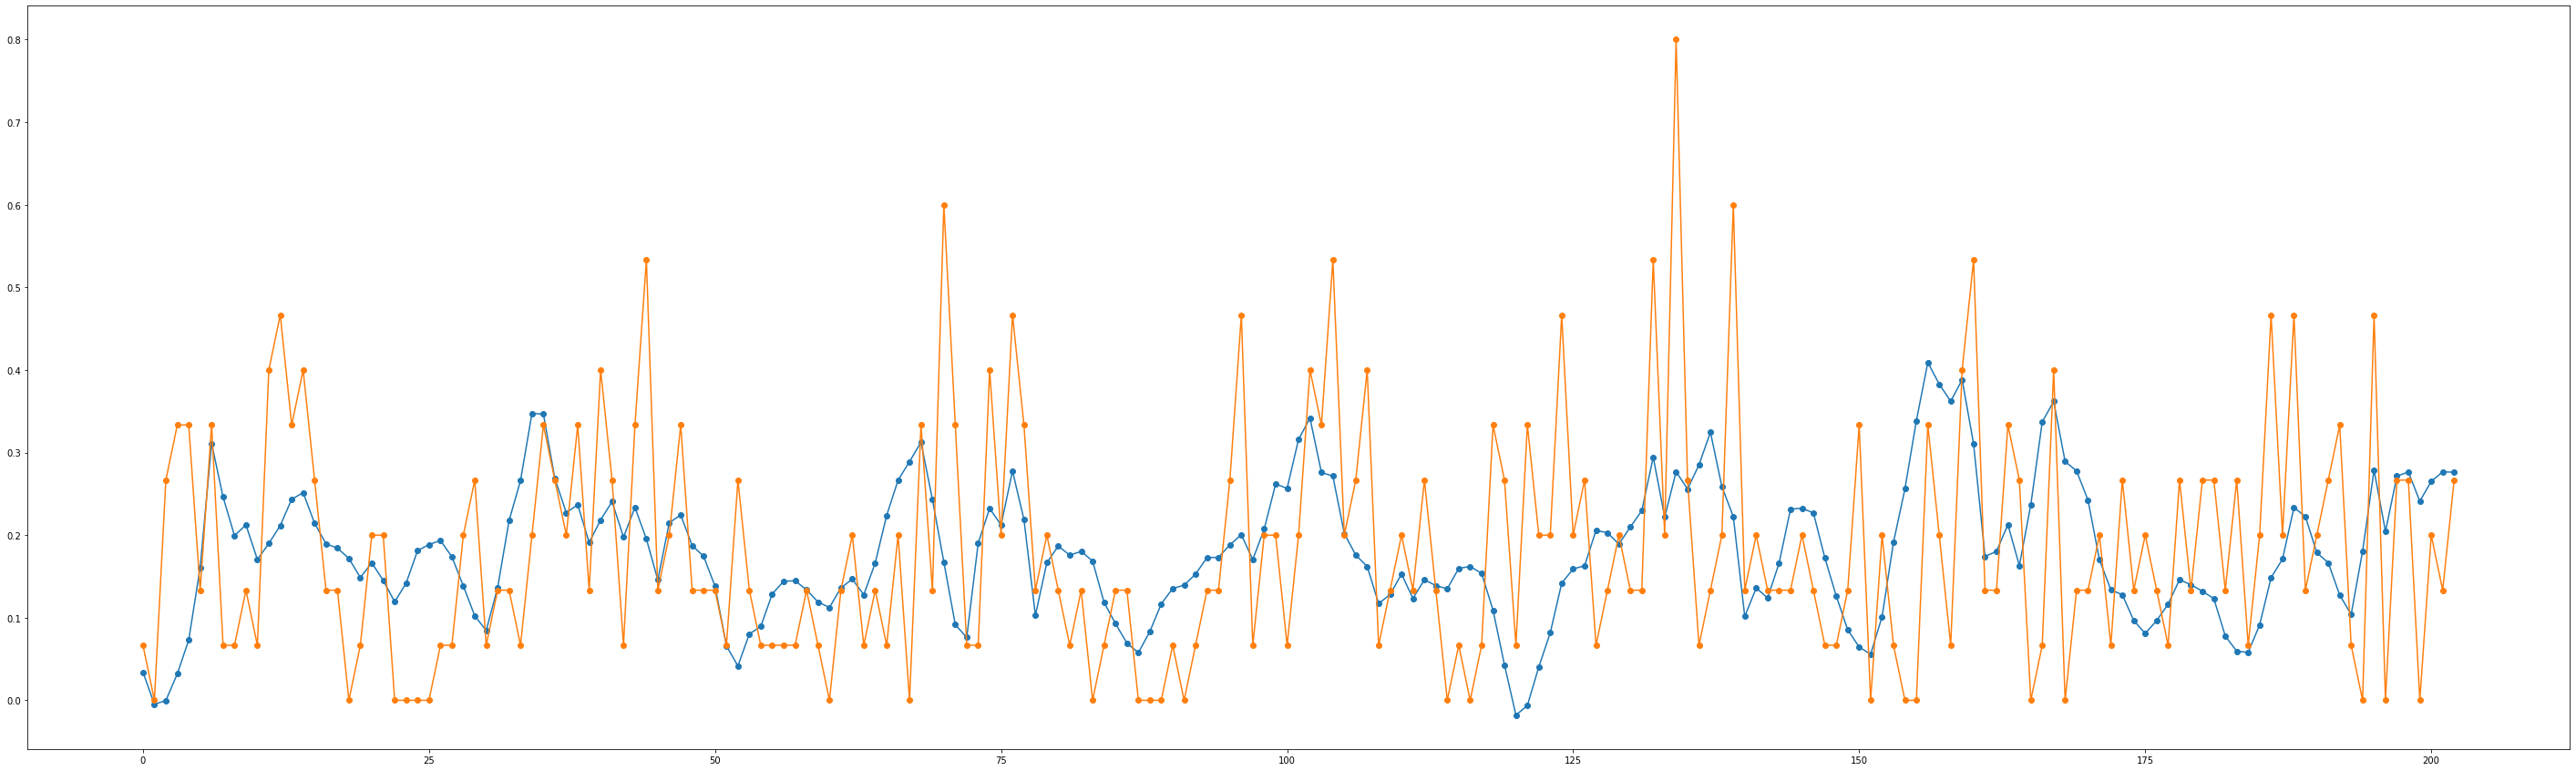

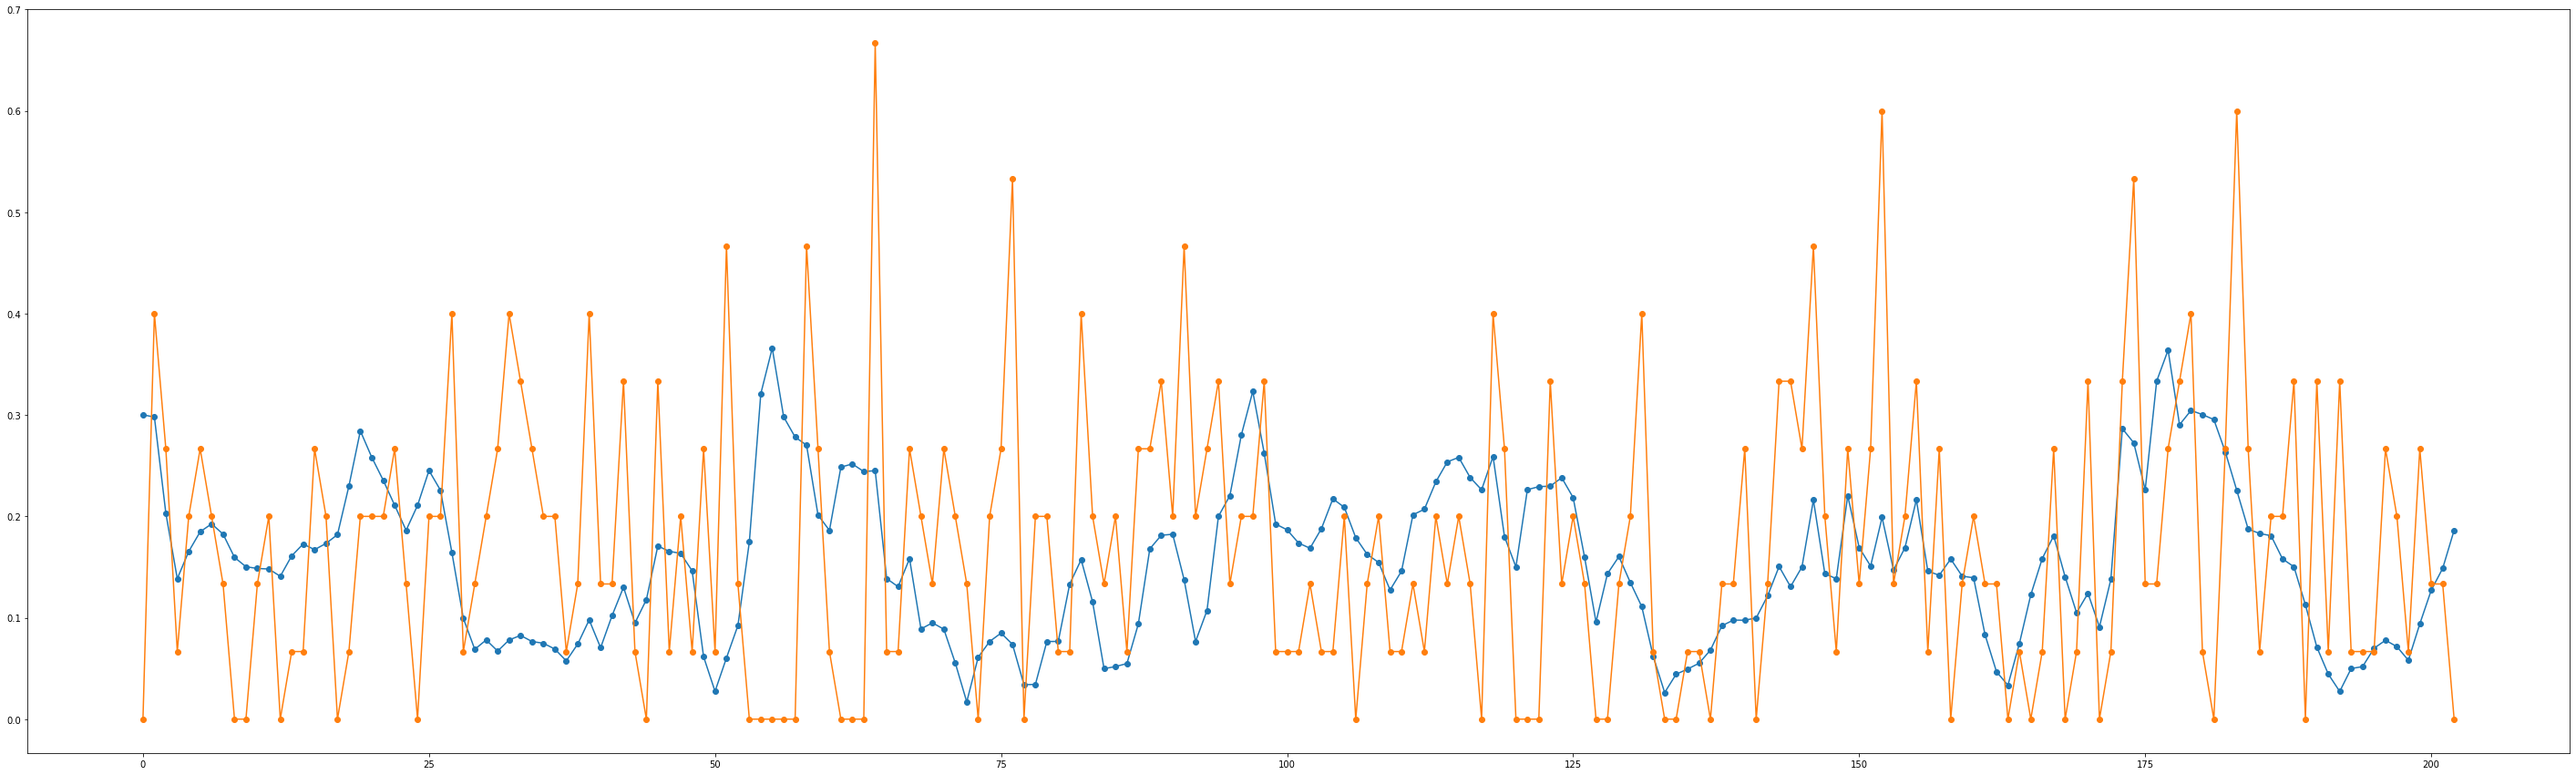

In [0]:
y_train_predict = regressor.predict(x_train)
y_val_predict = regressor.predict(x_val)
y_test_predict = regressor.predict(x_test)

plt.figure(figsize=(50,15))
plt.plot(y_train_predict[:,0],marker='o')
plt.plot(y_train[:,0],marker='o')
plt.title('Train')
plt.show()

plt.figure(figsize=(50,15))
plt.plot(y_val_predict[:,0],marker='o')
plt.plot(y_val[:,0],marker='o')

plt.figure(figsize=(50,15))
plt.plot(y_test_predict[:,0],marker='o')
plt.plot(y_test[:,0],marker='o')

# Using The Most Relevamt Features

---

## More relevant than the average relevance

In [0]:
corr = df_final.corr()

In [0]:
corr['qty_sales'].abs().mean()

0.42295285619137074

In [0]:
corr['qty_sales'].abs().std()

0.303496630307766

In [0]:
corr[corr['qty_sales'].abs()>corr['qty_sales'].abs().mean()]['qty_sales']

revenue_day               0.999454
rolling_mean_revenue_2    0.759145
rolling_mean_revenue_3    0.644159
rolling_mean_revenue_4    0.597827
rolling_mean_revenue_5    0.543864
rolling_mean_revenue_6    0.511707
rolling_mean_revenue_7    0.486419
rolling_mean_sales_2      0.759781
rolling_mean_sales_3      0.644780
rolling_mean_sales_4      0.598260
rolling_mean_sales_5      0.544332
rolling_mean_sales_6      0.512285
rolling_mean_sales_7      0.486284
qty_sales                 1.000000
Name: qty_sales, dtype: float64

In [0]:
dataset = df_final.loc[:,corr[corr['qty_sales'].abs()>corr['qty_sales'].abs().mean()]['qty_sales'].index]
dataset

revenue_day  rolling_mean_revenue_2  ...  rolling_mean_sales_7  qty_sales
index                                        ...                                 
d_1            1.77                   0.000  ...              0.000000        1.0
d_2            3.54                   2.655  ...              0.000000        2.0
d_3            7.08                   5.310  ...              0.000000        4.0
d_4            3.54                   5.310  ...              0.000000        2.0
d_5            5.31                   4.425  ...              0.000000        3.0
...             ...                     ...  ...                   ...        ...
d_1909         1.98                   2.970  ...              2.857143        1.0
d_1910         3.96                   2.970  ...              2.571429        2.0
d_1911         7.92                   5.940  ...              2.714286        4.0
d_1912         3.96                   5.940  ...              2.857143        2.0
d_1913         0.00                   1.980  ...              2.285714        0.0

[1913 rows x 14 columns]

In [0]:
train_limit = int(round((dataset.shape[0])*0.7,0))
val_limit = int(round((dataset.shape[0])*0.85,0))

df_train = dataset[:train_limit]
df_val = dataset[train_limit:val_limit]
df_test = dataset[val_limit:]

print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

(1339, 14)
(287, 14)
(287, 14)


In [0]:
df_train_norm,df_val_norm,df_test_norm = normalizing_data(df_train,df_val,df_test)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


[0.8        0.8        1.         0.96428571 0.82857143 0.84210526
 0.74468085 0.8        1.         0.96428571 0.82857143 0.84210526
 0.74468085 0.8       ]
[0.         0.         0.         0.         0.02857143 0.05263158
 0.08510638 0.         0.         0.         0.02857143 0.05263158
 0.08510638 0.        ]


[0.66666667 0.65       0.73913043 0.78571429 0.71428571 0.76315789
 0.68085106 0.65       0.73913043 0.78571429 0.71428571 0.76315789
 0.68085106 0.66666667]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.71676395e-16 5.26315789e-02 1.06382979e-01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.26315789e-02
 1.06382979e-01 0.00000000e+00]
-------------------------
(1339, 14)
(287, 14)
(287, 14)


In [0]:
time_steps = 84
future_steps = 28
n_features = df_train_norm.shape[1]
x_train,x_test,x_val,y_train,y_val,y_test = Regressor(future_steps = future_steps,time_steps = time_steps,n_features = n_features,df_train = df_train_norm,df_val = df_val_norm,df_test = df_test_norm)

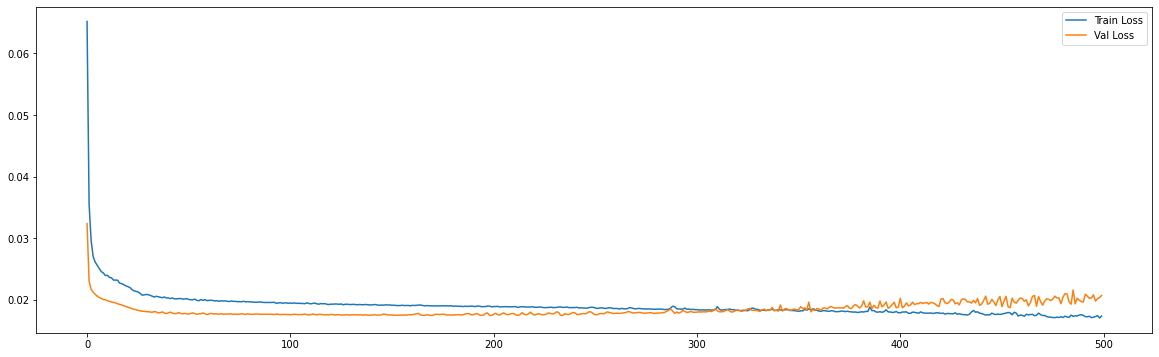

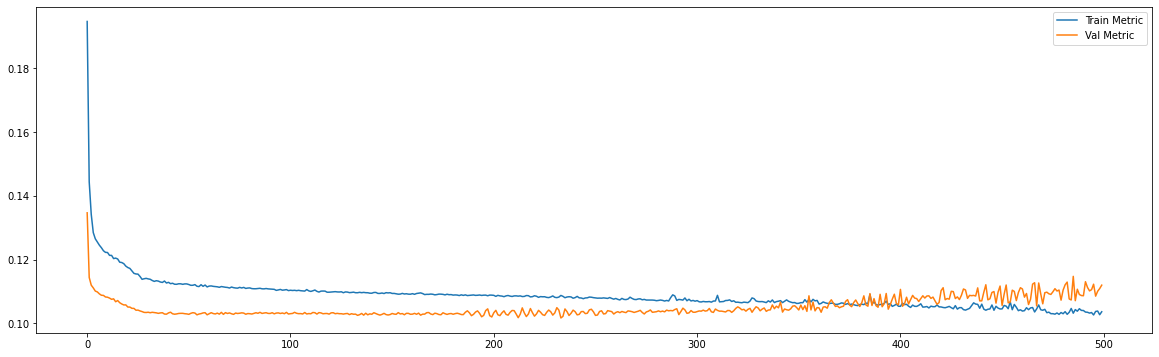



37/37 [==============================] - 0s 11ms/step - loss: 0.0166 - mae: 0.1018
loss and metric train data [0.01664927415549755, 0.10177914798259735]
7/7 [==============================] - 0s 9ms/step - loss: 0.0207 - mae: 0.1120
loss and metric val data [0.020705321803689003, 0.11199500411748886]
7/7 [==============================] - 0s 9ms/step - loss: 0.0207 - mae: 0.1137
loss and metric test data [0.02072220668196678, 0.11367499083280563]


In [0]:
regressor = Sequential()
regressor.add(LSTM(units=50, return_sequences=False, input_shape=(time_steps, n_features))) 
regressor.add(Dropout(0.2))
regressor.add(Dense(units=future_steps))

#Compiling the LSTM
adam = optimizers.Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999, decay = 0.0)
regressor.compile(optimizer = adam, loss = 'mse', metrics=['mae'])

#Fitting to traning set
history = regressor.fit(x_train, y_train, validation_data=(x_val,y_val), 
                        epochs = 500, batch_size=100, verbose = 0, shuffle= False)

plt.figure(figsize=(20,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train Loss', 'Val Loss'])

plt.figure(figsize=(20,6))
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.legend(['Train Metric', 'Val Metric'])
plt.show()

print('\n')
print('loss and metric train data',regressor.evaluate(x_train,y_train))
print('loss and metric val data',regressor.evaluate(x_val,y_val))
print('loss and metric test data',regressor.evaluate(x_test,y_test))

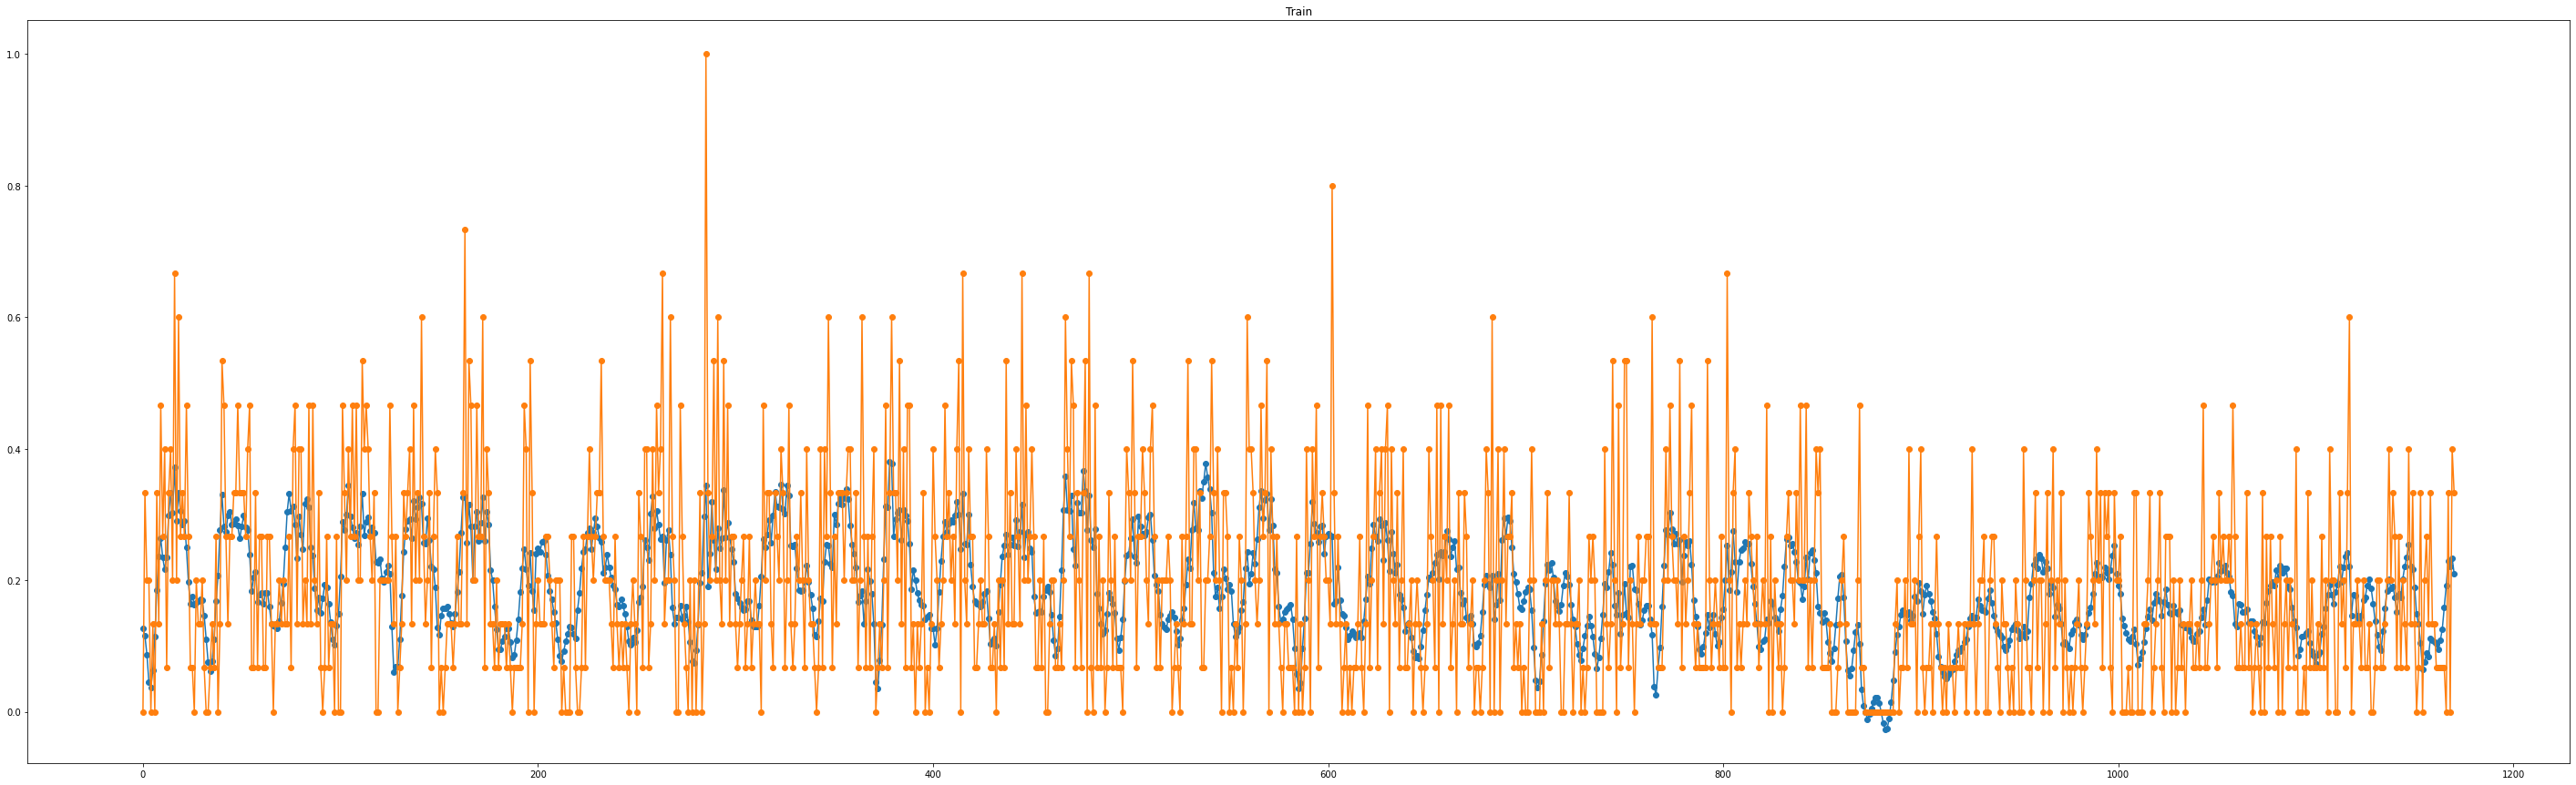

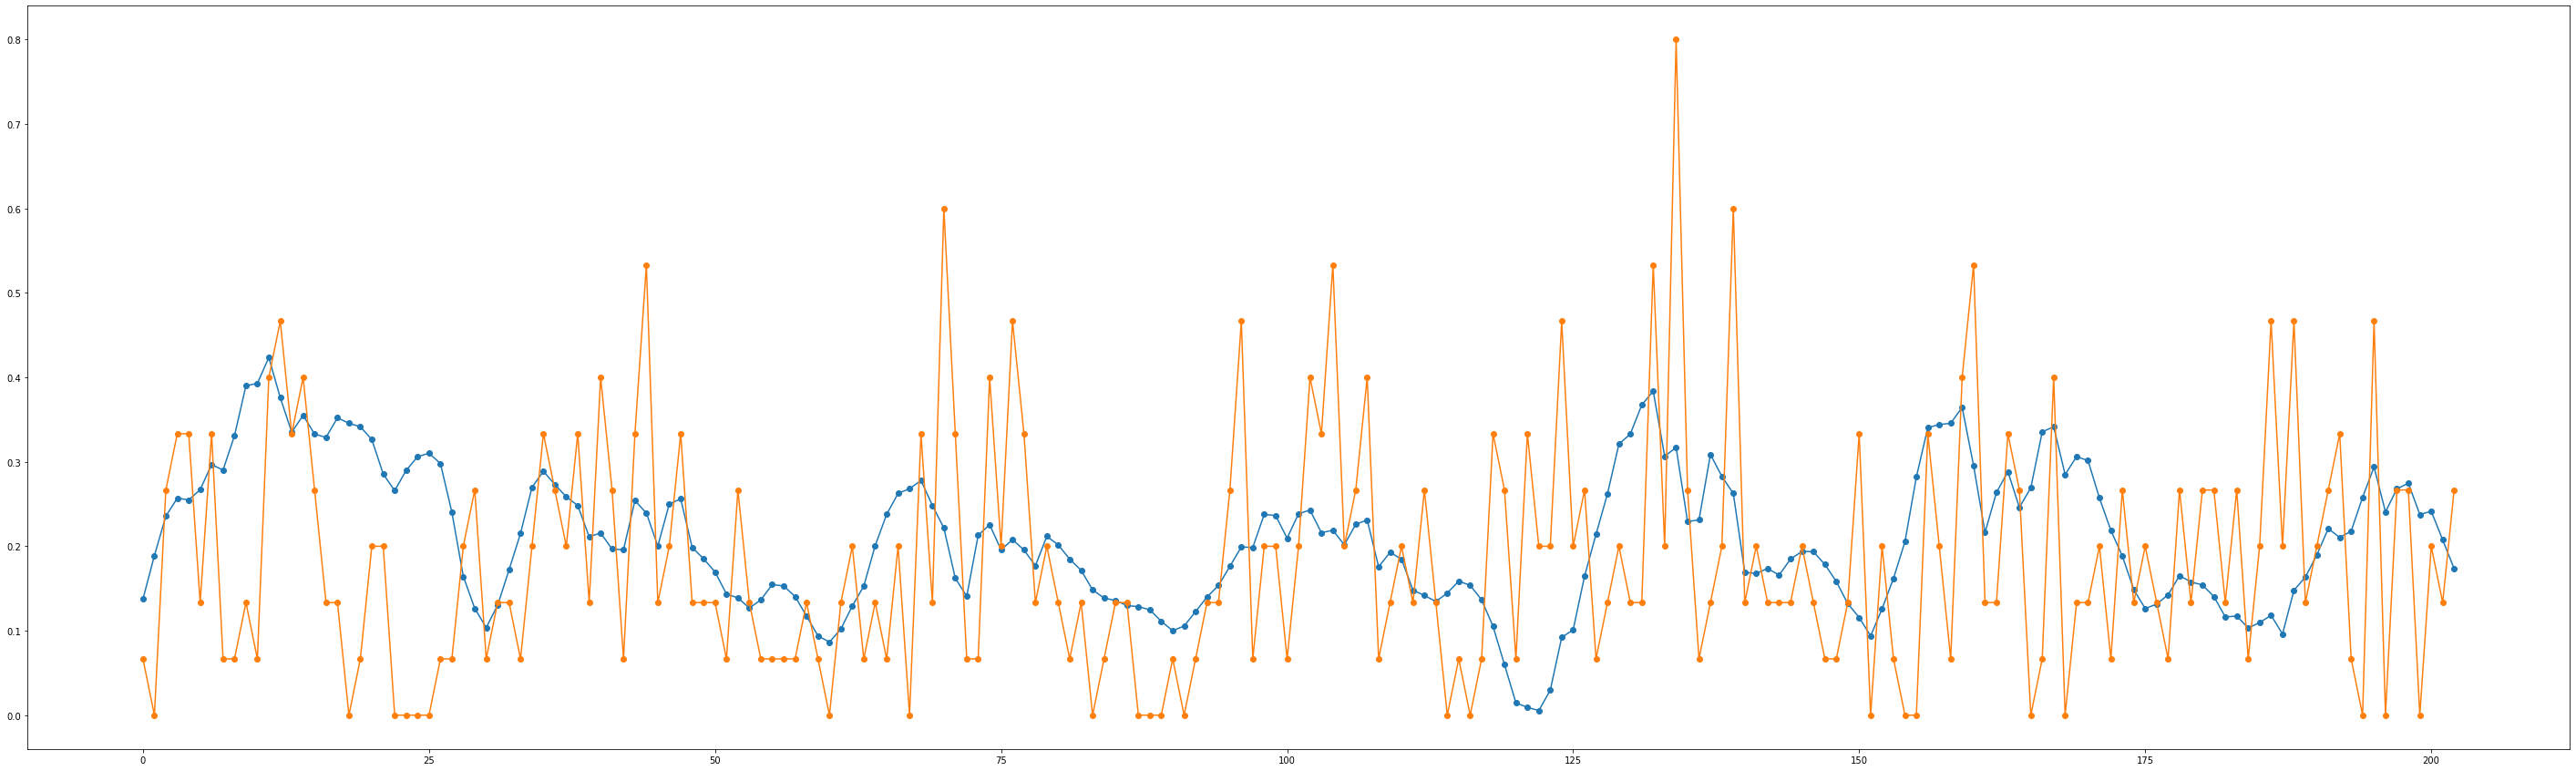

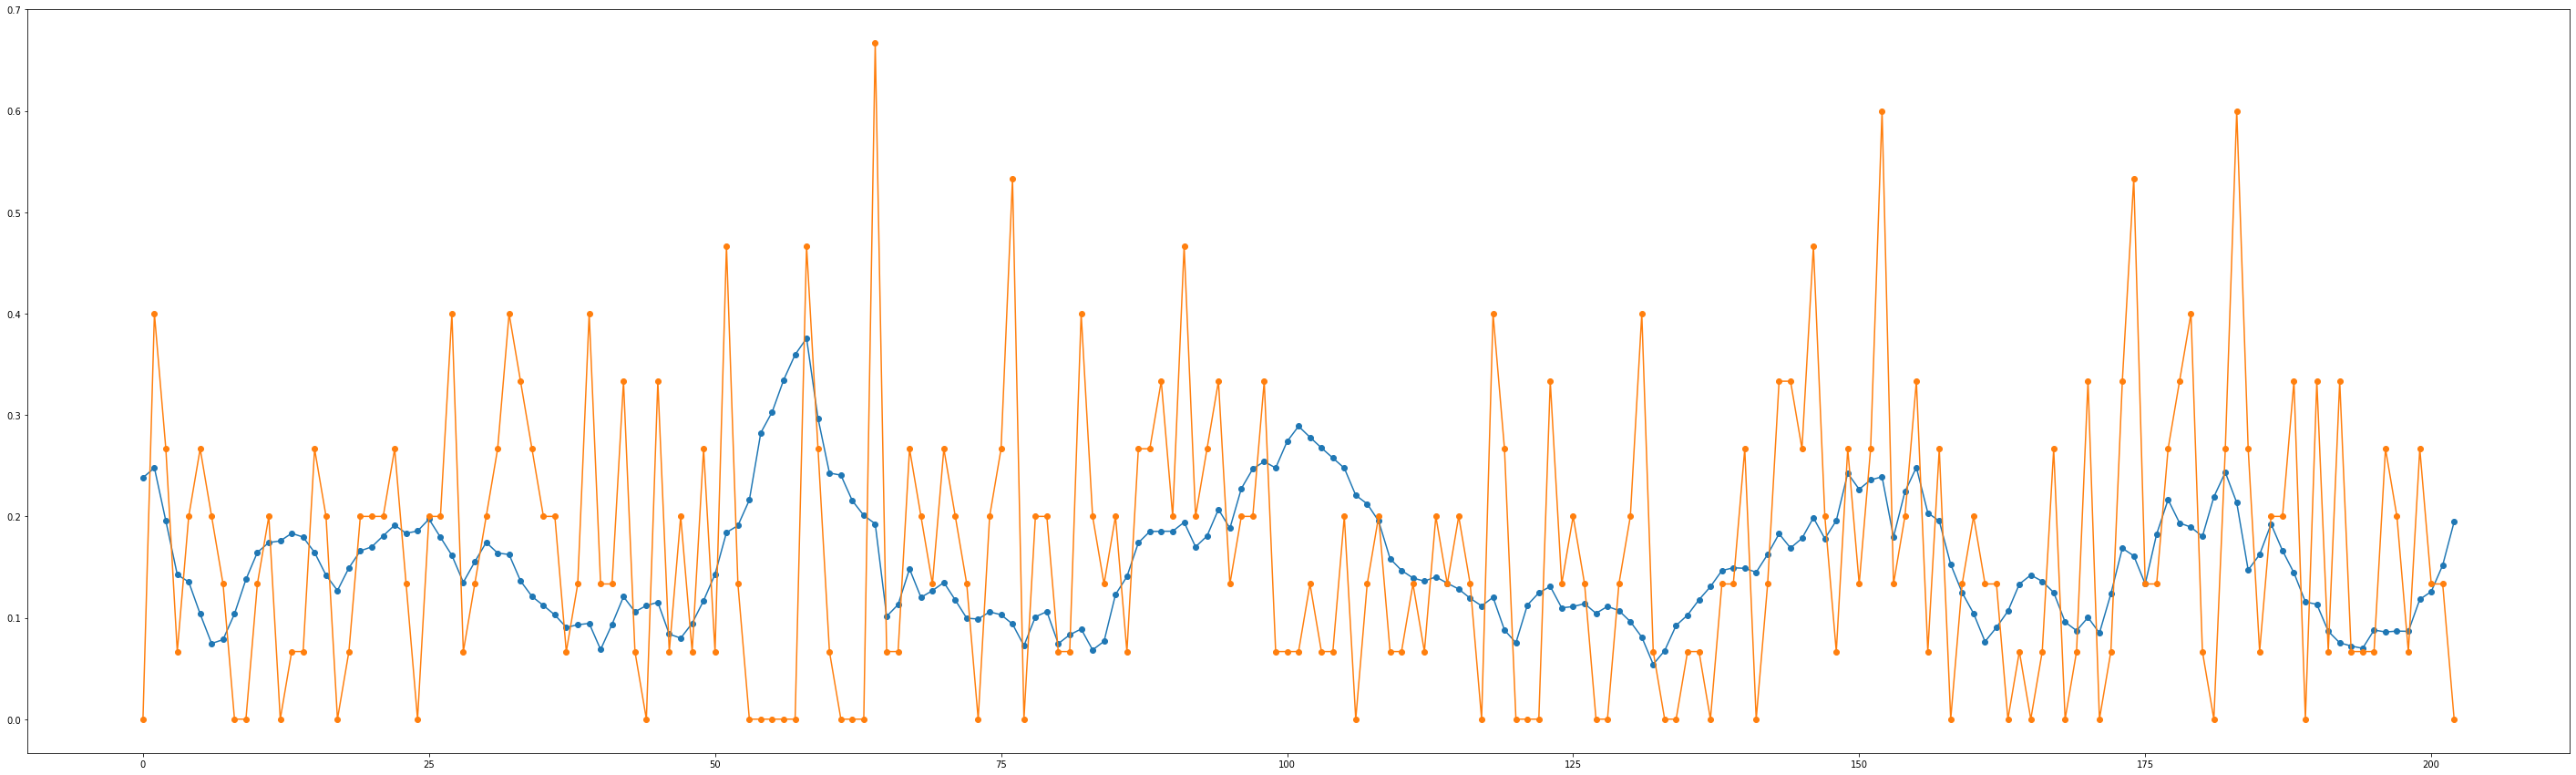

In [0]:
y_train_predict = regressor.predict(x_train)
y_val_predict = regressor.predict(x_val)
y_test_predict = regressor.predict(x_test)

plt.figure(figsize=(50,15))
plt.plot(y_train_predict[:,0],marker='o')
plt.plot(y_train[:,0],marker='o')
plt.title('Train')
plt.show()

plt.figure(figsize=(50,15))
plt.plot(y_val_predict[:,0],marker='o')
plt.plot(y_val[:,0],marker='o')

plt.figure(figsize=(50,15))
plt.plot(y_test_predict[:,0],marker='o')
plt.plot(y_test[:,0],marker='o')

# Outlier Treatment

---

None of the approachs above had improved generalization, now lets try to deal with some outliers

In [0]:
df_outlier = df_final.copy()

## One Feature

---

Using Only qty_sales as input feature

### Spliting Data

In [0]:
train_limit = int(round((df_outlier['qty_sales'].shape[0])*0.7,0))
val_limit = int(round((df_outlier['qty_sales'].shape[0])*0.85,0))

df_train = df_outlier['qty_sales'][:train_limit]
df_val = df_outlier['qty_sales'][train_limit:val_limit]
df_test = df_outlier['qty_sales'][val_limit:]

print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

(1339,)
(287,)
(287,)


### Dealing with Outliers

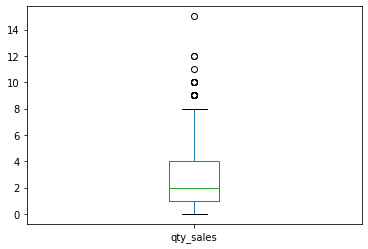

In [0]:
df_train.plot.box()

In [0]:
print(df_train[df_train>df_train.quantile(0.8)].shape)
print(df_train[df_train>df_train.quantile(0.9)].shape)
print(df_train[df_train>df_train.quantile(0.95)].shape)

(183,)
(101,)
(51,)


In [0]:
df_train[df_train>df_train.quantile(0.9)] = df_train.quantile(0.9)

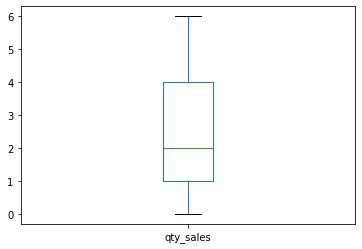

In [0]:
df_train.plot.box()

### Normalizing Data

In [0]:
df_train_norm,df_val_norm,df_test_norm = normalizing_data(df_train,df_val,df_test)

[1.]
[0.]


[2.]
[0.]


[1.66666667]
[0.]
-------------------------
(1339, 1)
(287, 1)
(287, 1)


### Preprocessing

In [0]:
time_steps = 84
future_steps = 28
n_features = df_train_norm.shape[1]
x_train,x_test,x_val,y_train,y_val,y_test = Regressor(future_steps = future_steps,time_steps = time_steps,n_features = n_features,df_train = df_train_norm,df_val = df_val_norm,df_test = df_test_norm)

### LSTM

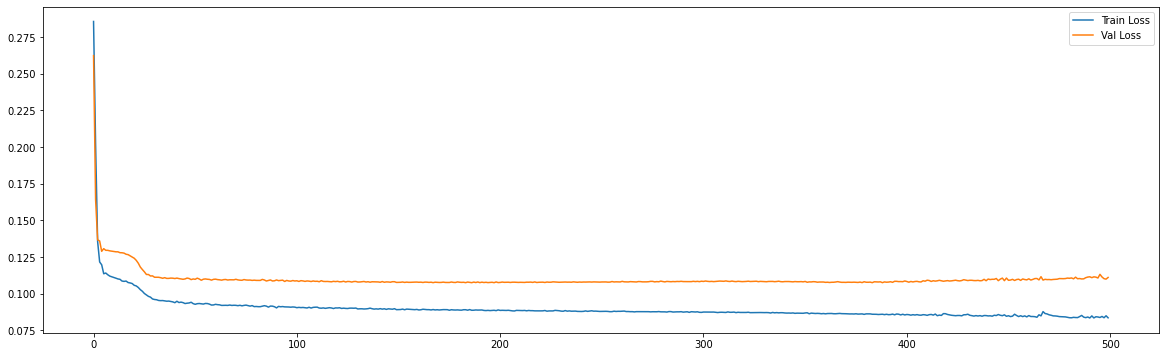

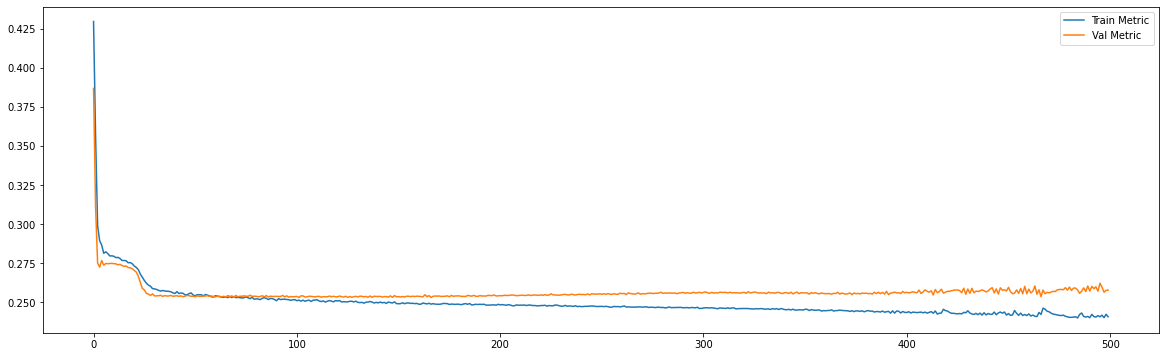



37/37 [==============================] - 0s 4ms/step - loss: 0.0824 - mae: 0.2385
loss and metric train data [0.08241138607263565, 0.2385196089744568]
7/7 [==============================] - 0s 4ms/step - loss: 0.1110 - mae: 0.2577
loss and metric val data [0.11101808398962021, 0.2576914131641388]
7/7 [==============================] - 0s 4ms/step - loss: 0.1373 - mae: 0.2909
loss and metric test data [0.13729077577590942, 0.29093778133392334]


In [0]:
regressor = Sequential()
regressor.add(LSTM(units=50, return_sequences=False, input_shape=(time_steps, n_features))) 
regressor.add(Dropout(0.2))
regressor.add(Dense(units=future_steps))

#Compiling the LSTM
adam = optimizers.Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999, decay = 0.0)
regressor.compile(optimizer = adam, loss = 'mse', metrics=['mae'])

#Fitting to traning set
history = regressor.fit(x_train, y_train, validation_data=(x_val,y_val), 
                        epochs = 500, batch_size=100, verbose = 0, shuffle= False)

plt.figure(figsize=(20,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train Loss', 'Val Loss'])

plt.figure(figsize=(20,6))
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.legend(['Train Metric', 'Val Metric'])
plt.show()

print('\n')
print('loss and metric train data',regressor.evaluate(x_train,y_train))
print('loss and metric val data',regressor.evaluate(x_val,y_val))
print('loss and metric test data',regressor.evaluate(x_test,y_test))

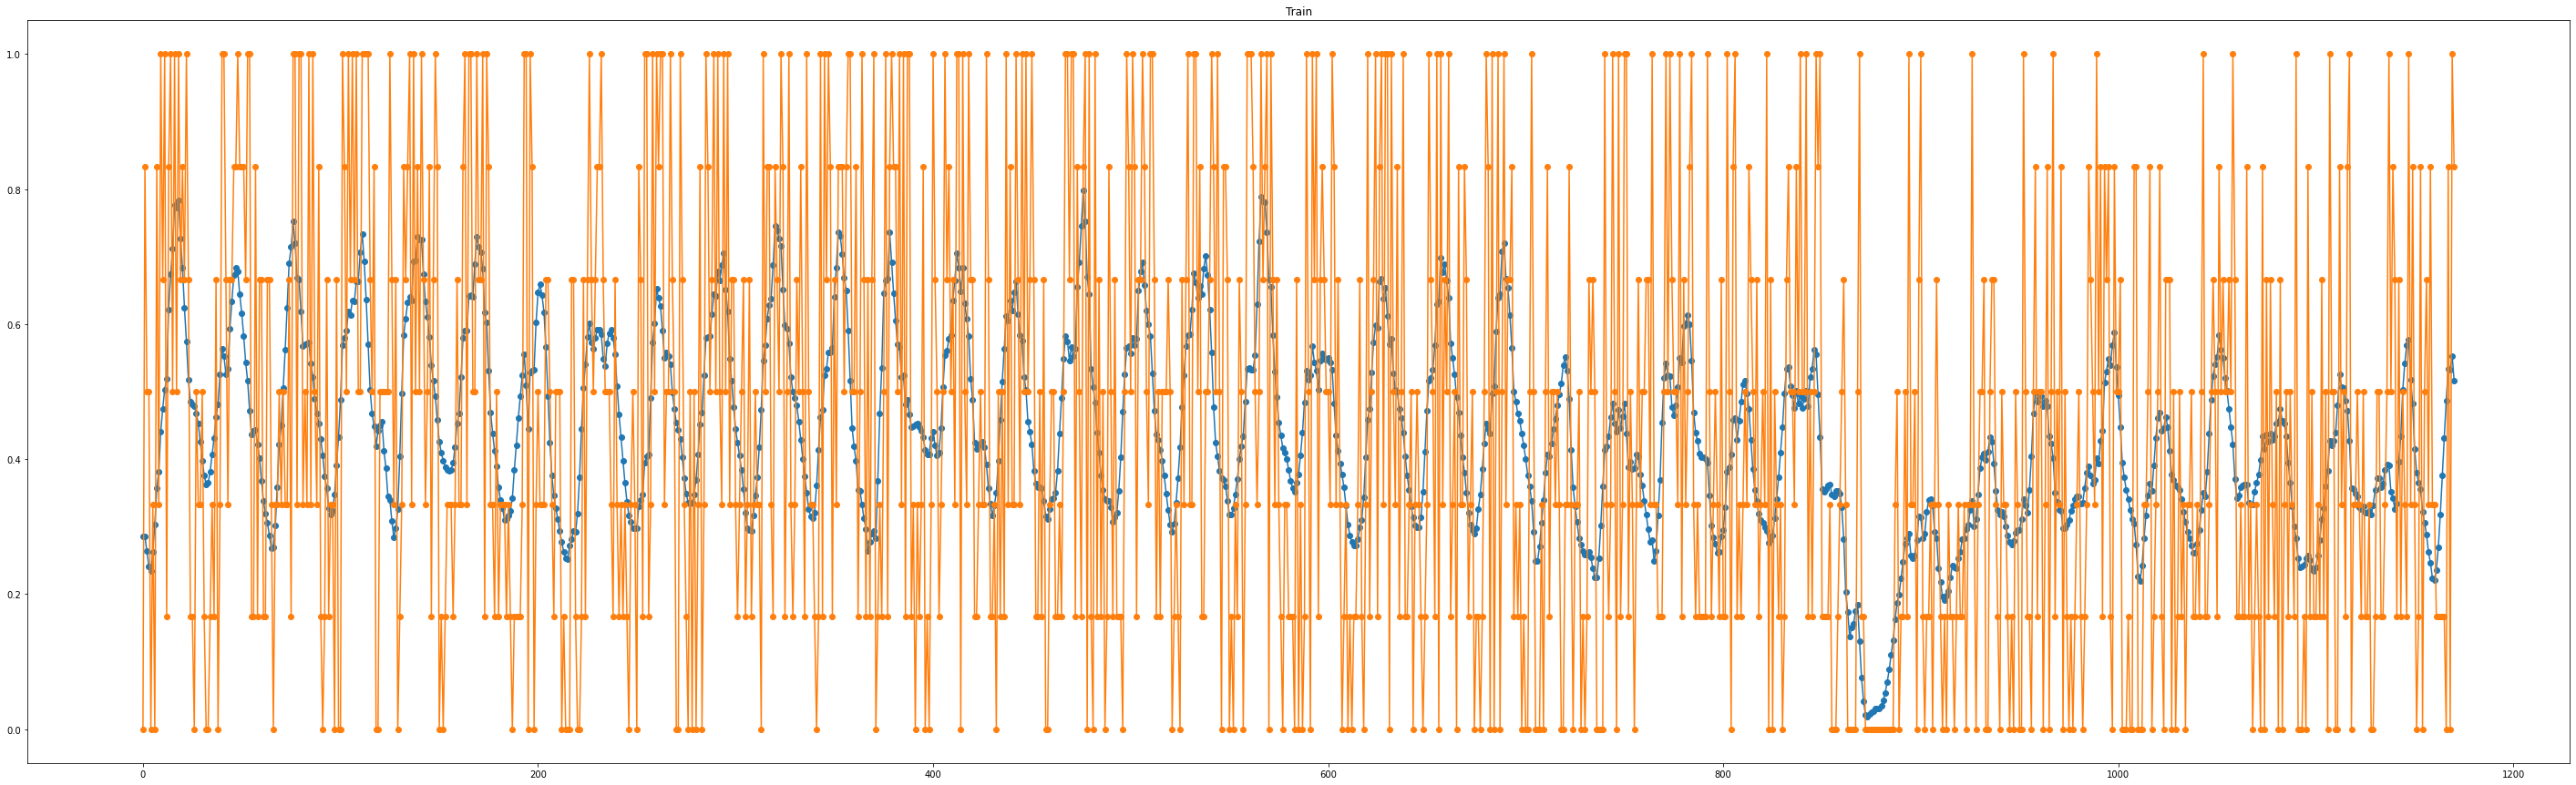

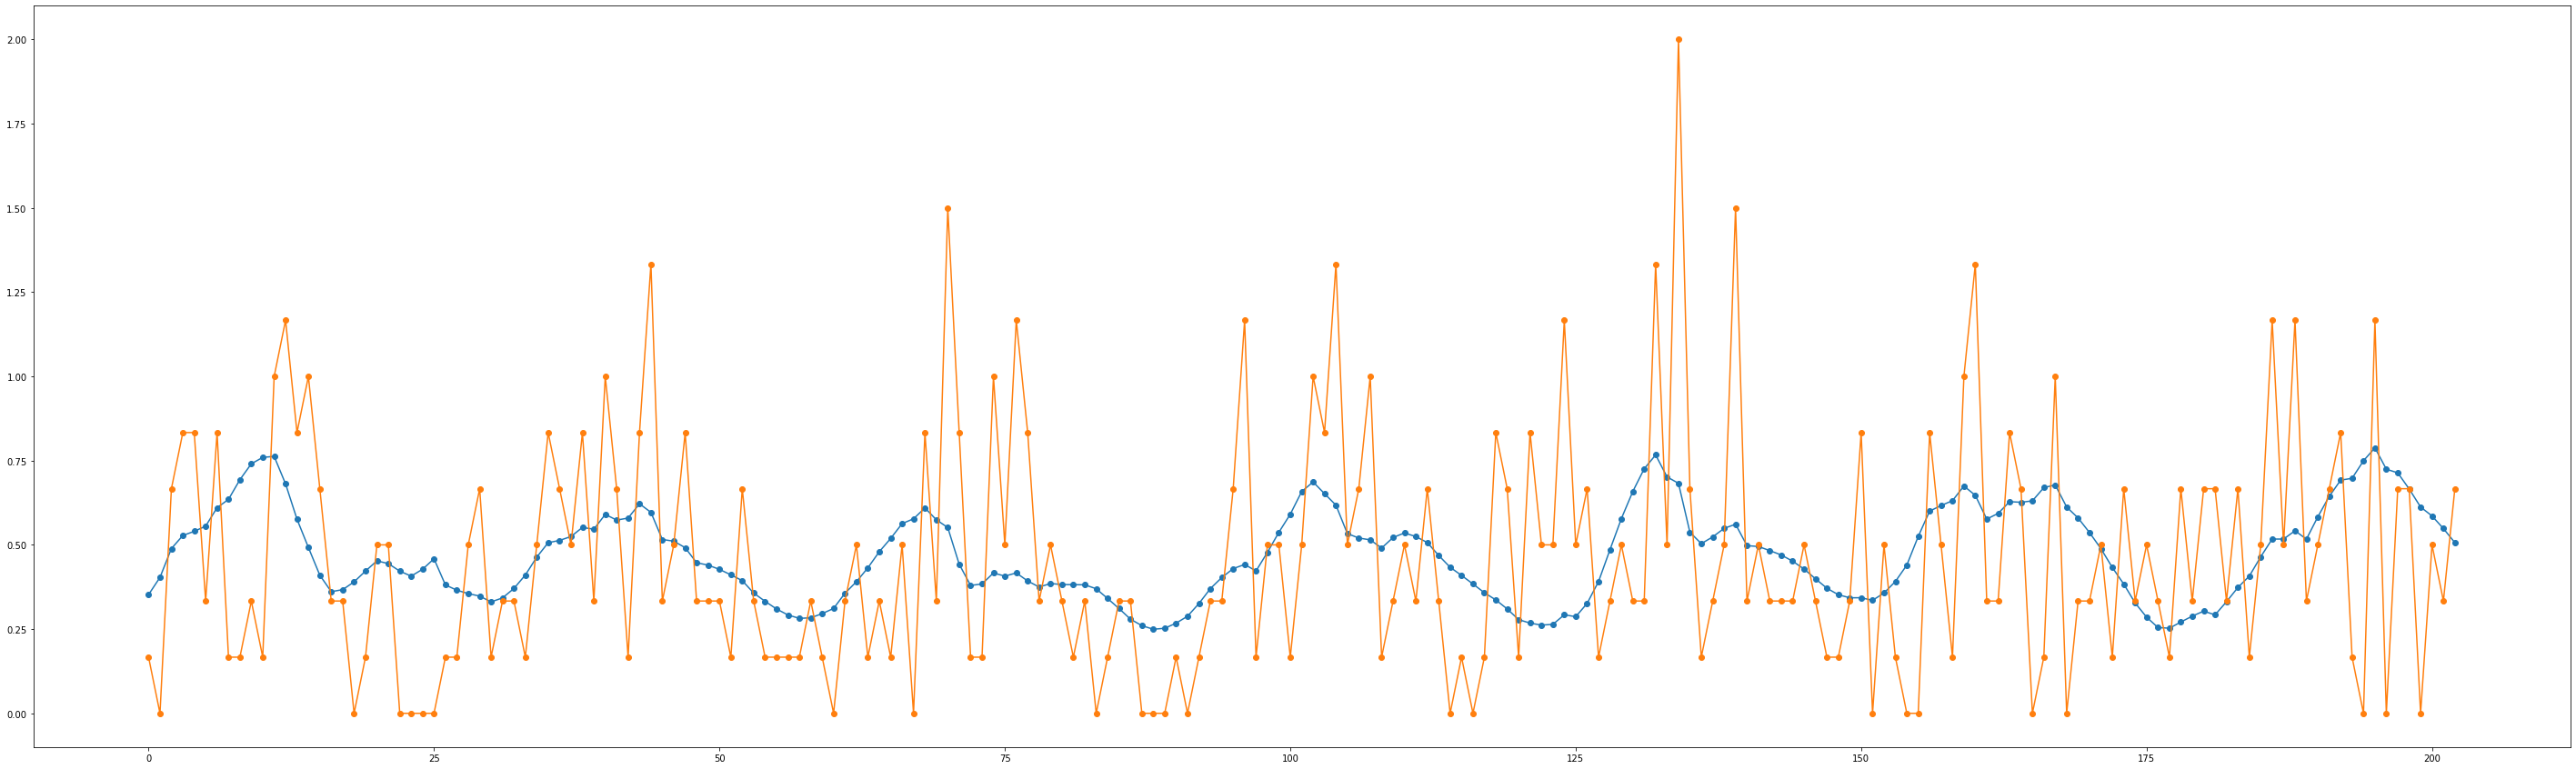

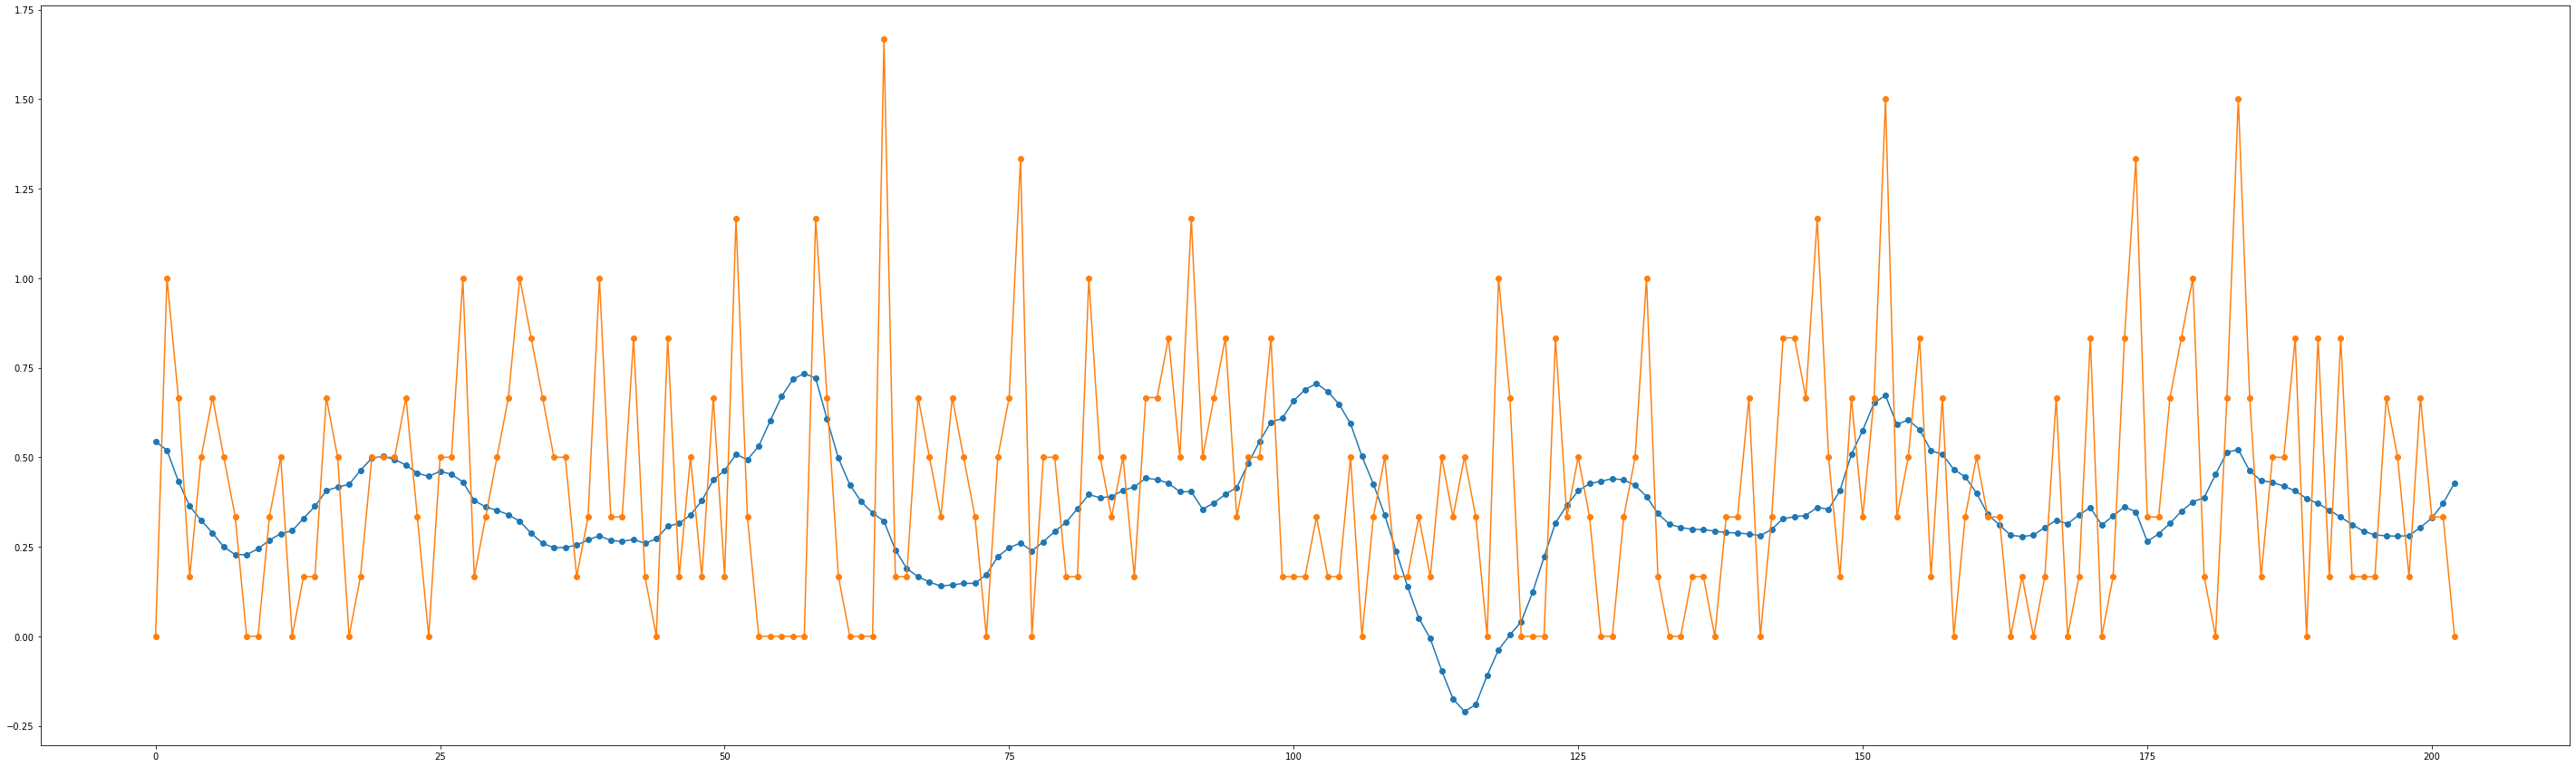

In [0]:
y_train_predict = regressor.predict(x_train)
y_val_predict = regressor.predict(x_val)
y_test_predict = regressor.predict(x_test)

plt.figure(figsize=(50,15))
plt.plot(y_train_predict[:,0],marker='o')
plt.plot(y_train[:,0],marker='o')
plt.title('Train')
plt.show()

plt.figure(figsize=(50,15))
plt.plot(y_val_predict[:,0],marker='o')
plt.plot(y_val[:,0],marker='o')

plt.figure(figsize=(50,15))
plt.plot(y_test_predict[:,0],marker='o')
plt.plot(y_test[:,0],marker='o')

## All Features

###Spliting Data

In [0]:
train_limit = int(round((df_outlier.shape[0])*0.7,0))
val_limit = int(round((df_outlier.shape[0])*0.85,0))

df_train = df_outlier[:train_limit]
df_val = df_outlier[train_limit:val_limit]
df_test = df_outlier[val_limit:]

print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

(1339, 24)
(287, 24)
(287, 24)


### Dealing with Outliers

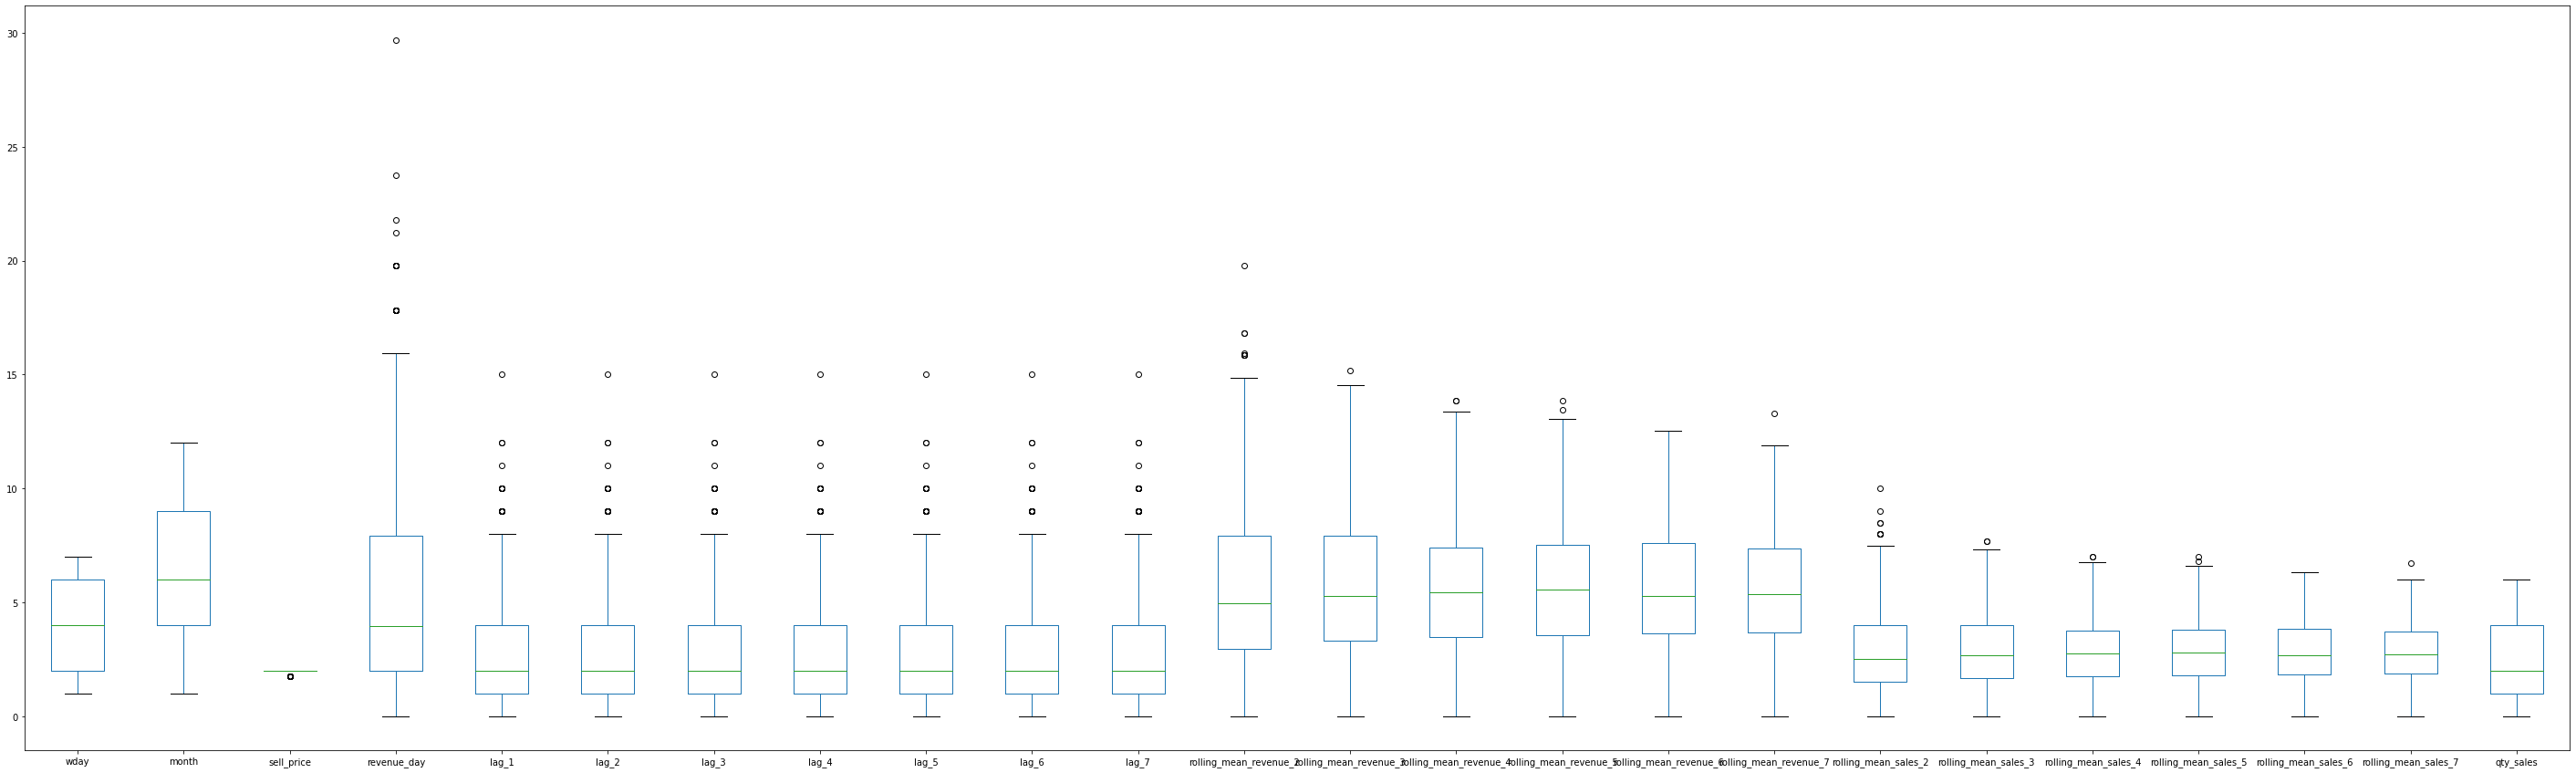

In [0]:
df_train.plot.box(figsize=(50,15))

In [0]:
for column in df_train.columns:
  try:
    df_train.loc[df_train[column]>df_train[column].quantile(0.9),column] = df_train[column].quantile(0.9)
  except:
    pass

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


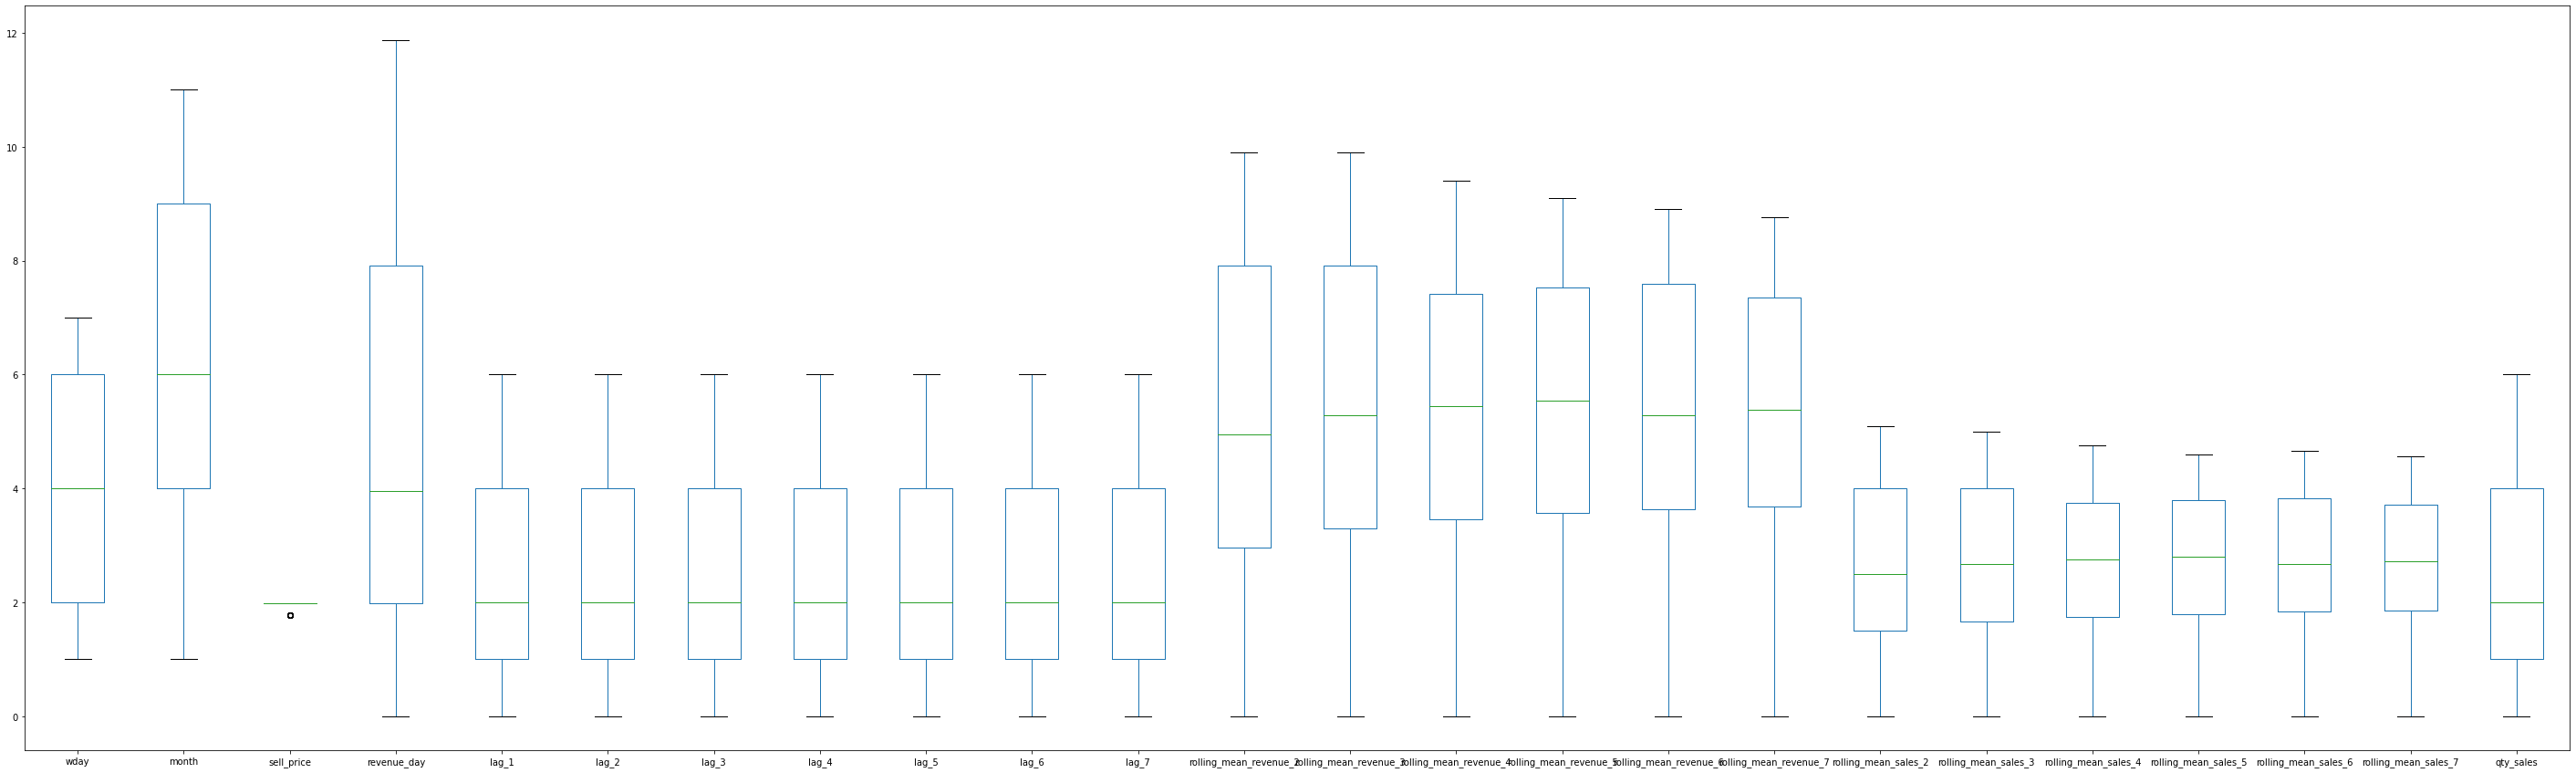

In [0]:
df_train.plot.box(figsize=(50,15))

### Normalizing

In [0]:
df_train_norm,df_val_norm,df_test_norm = normalizing_data(df_train,df_val,df_test)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


[1.         1.1        1.         2.         2.         2.
 2.         2.         2.         2.         2.         1.6
 1.53333333 1.42105263 1.26086957 1.18518519 1.12903226 1.56862745
 1.53333333 1.42105263 1.26086957 1.14285714 1.09375    2.        ]
[0.         0.         1.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.04347826 0.07407407 0.12903226 0.
 0.         0.         0.04347826 0.07142857 0.125      0.        ]


[1.         1.1        1.         1.66666667 1.66666667 1.66666667
 1.66666667 1.66666667 1.66666667 1.66666667 1.66666667 1.3
 1.13333333 1.15789474 1.08695652 1.07407407 1.03225806 1.2745098
 1.13333333 1.15789474 1.08695652 1.03571429 1.         1.66666667]
[0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e

### Preprocessing

In [0]:
time_steps = 84
future_steps = 28
n_features = df_train_norm.shape[1]
x_train,x_test,x_val,y_train,y_val,y_test = Regressor(future_steps = future_steps,time_steps = time_steps,n_features = n_features,df_train = df_train_norm,df_val = df_val_norm,df_test = df_test_norm)

### LSTM

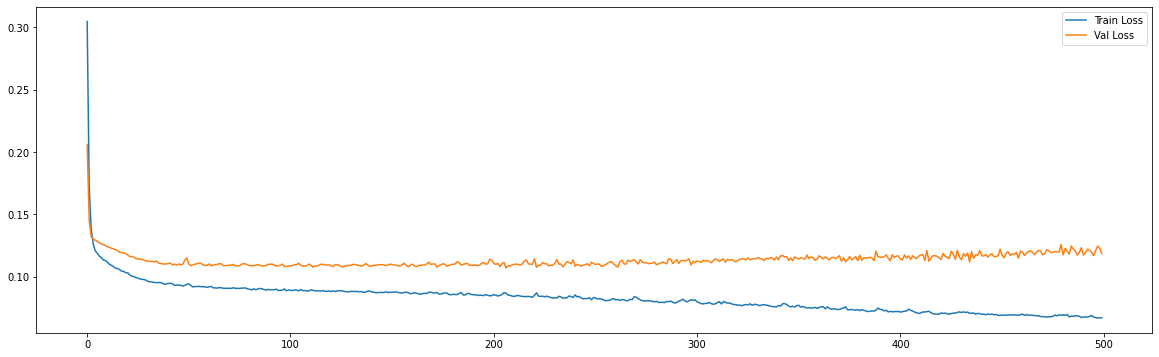

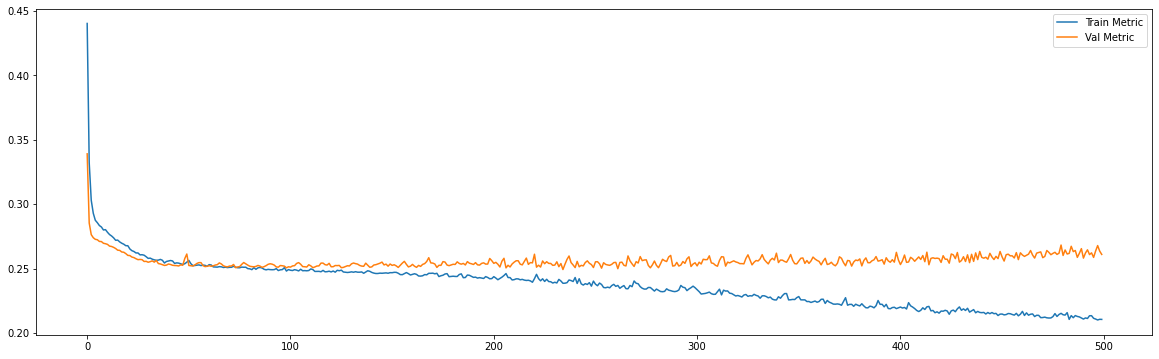



37/37 [==============================] - 0s 4ms/step - loss: 0.0649 - mae: 0.2073
loss and metric train data [0.06491587311029434, 0.20734912157058716]
7/7 [==============================] - 0s 4ms/step - loss: 0.1186 - mae: 0.2610
loss and metric val data [0.11859209835529327, 0.26103904843330383]
7/7 [==============================] - 0s 4ms/step - loss: 0.1394 - mae: 0.3005
loss and metric test data [0.1393786519765854, 0.30054420232772827]


In [0]:
regressor = Sequential()
regressor.add(LSTM(units=50, return_sequences=False, input_shape=(time_steps, n_features))) 
regressor.add(Dropout(0.2))
regressor.add(Dense(units=future_steps))

#Compiling the LSTM
adam = optimizers.Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999, decay = 0.0)
regressor.compile(optimizer = adam, loss = 'mse', metrics=['mae'])

#Fitting to traning set
history = regressor.fit(x_train, y_train, validation_data=(x_val,y_val), 
                        epochs = 500, batch_size=100, verbose = 0, shuffle= False)

plt.figure(figsize=(20,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train Loss', 'Val Loss'])

plt.figure(figsize=(20,6))
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.legend(['Train Metric', 'Val Metric'])
plt.show()

print('\n')
print('loss and metric train data',regressor.evaluate(x_train,y_train))
print('loss and metric val data',regressor.evaluate(x_val,y_val))
print('loss and metric test data',regressor.evaluate(x_test,y_test))

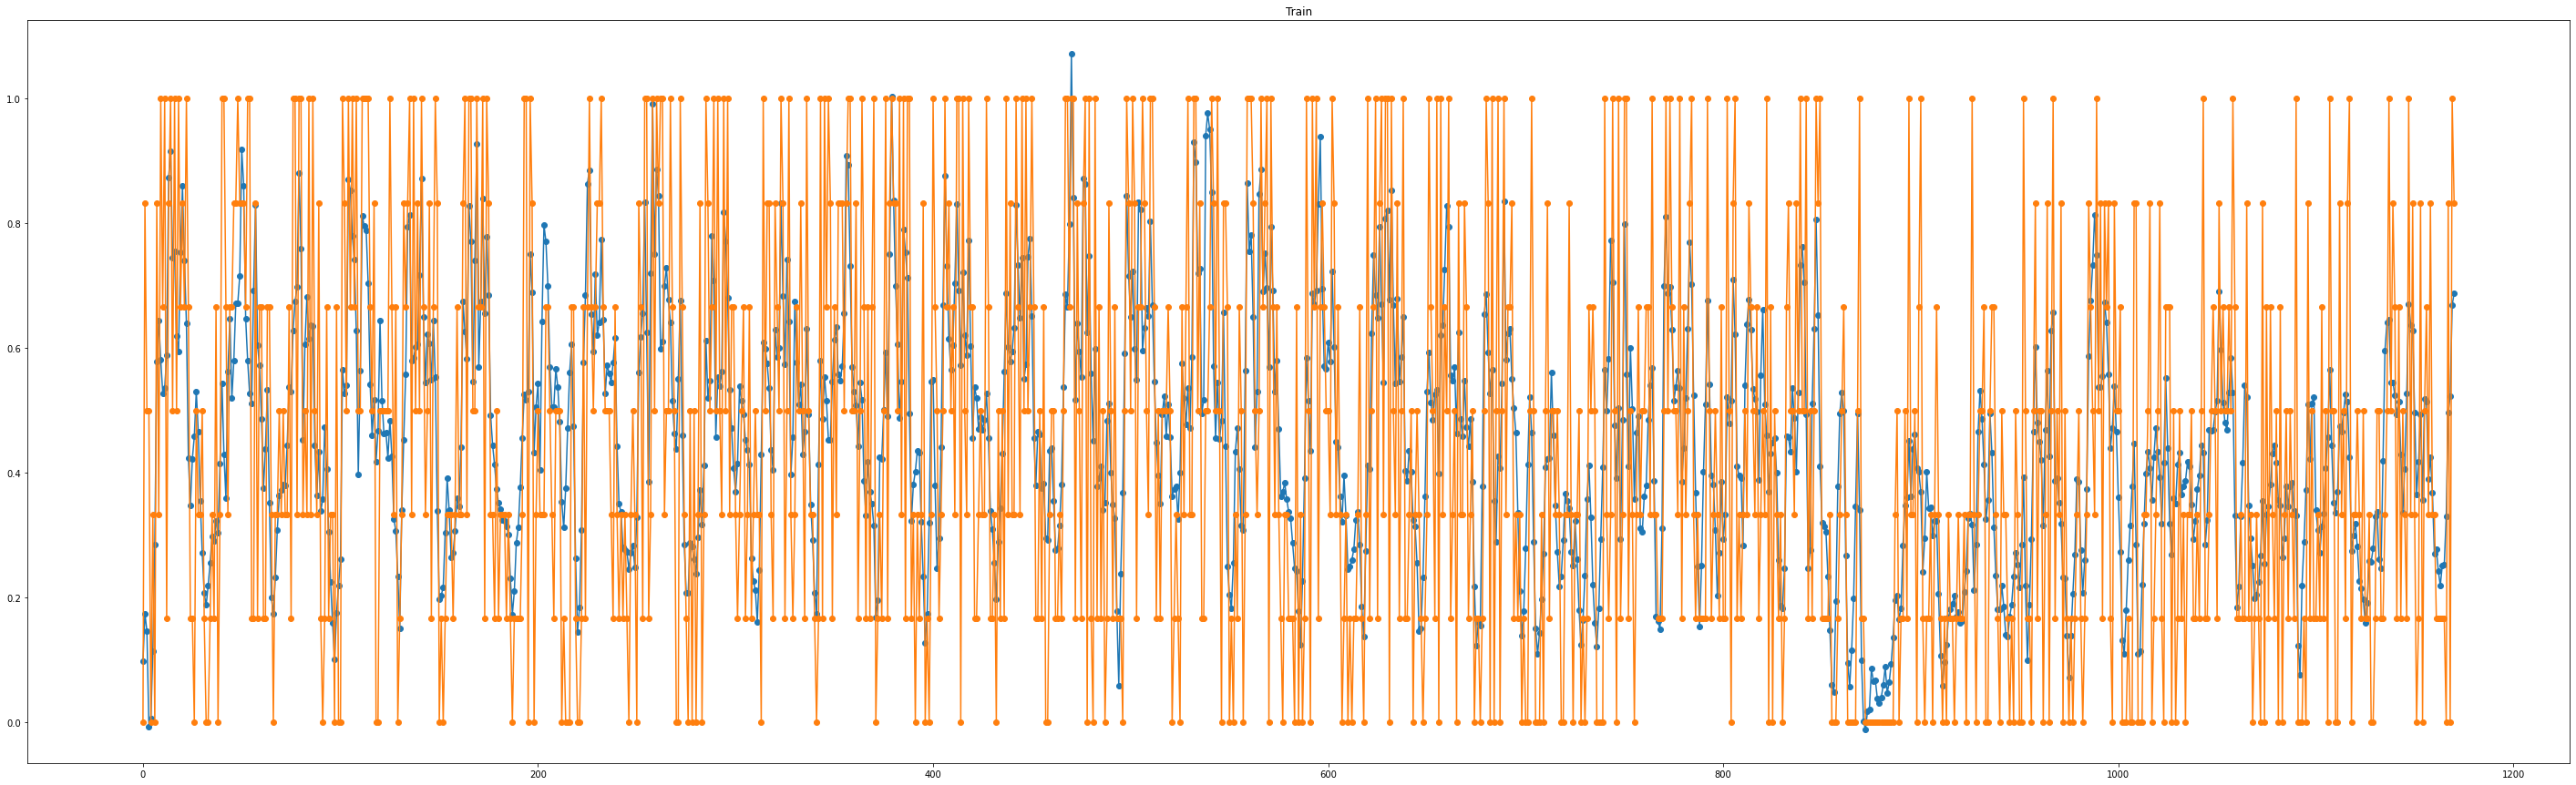

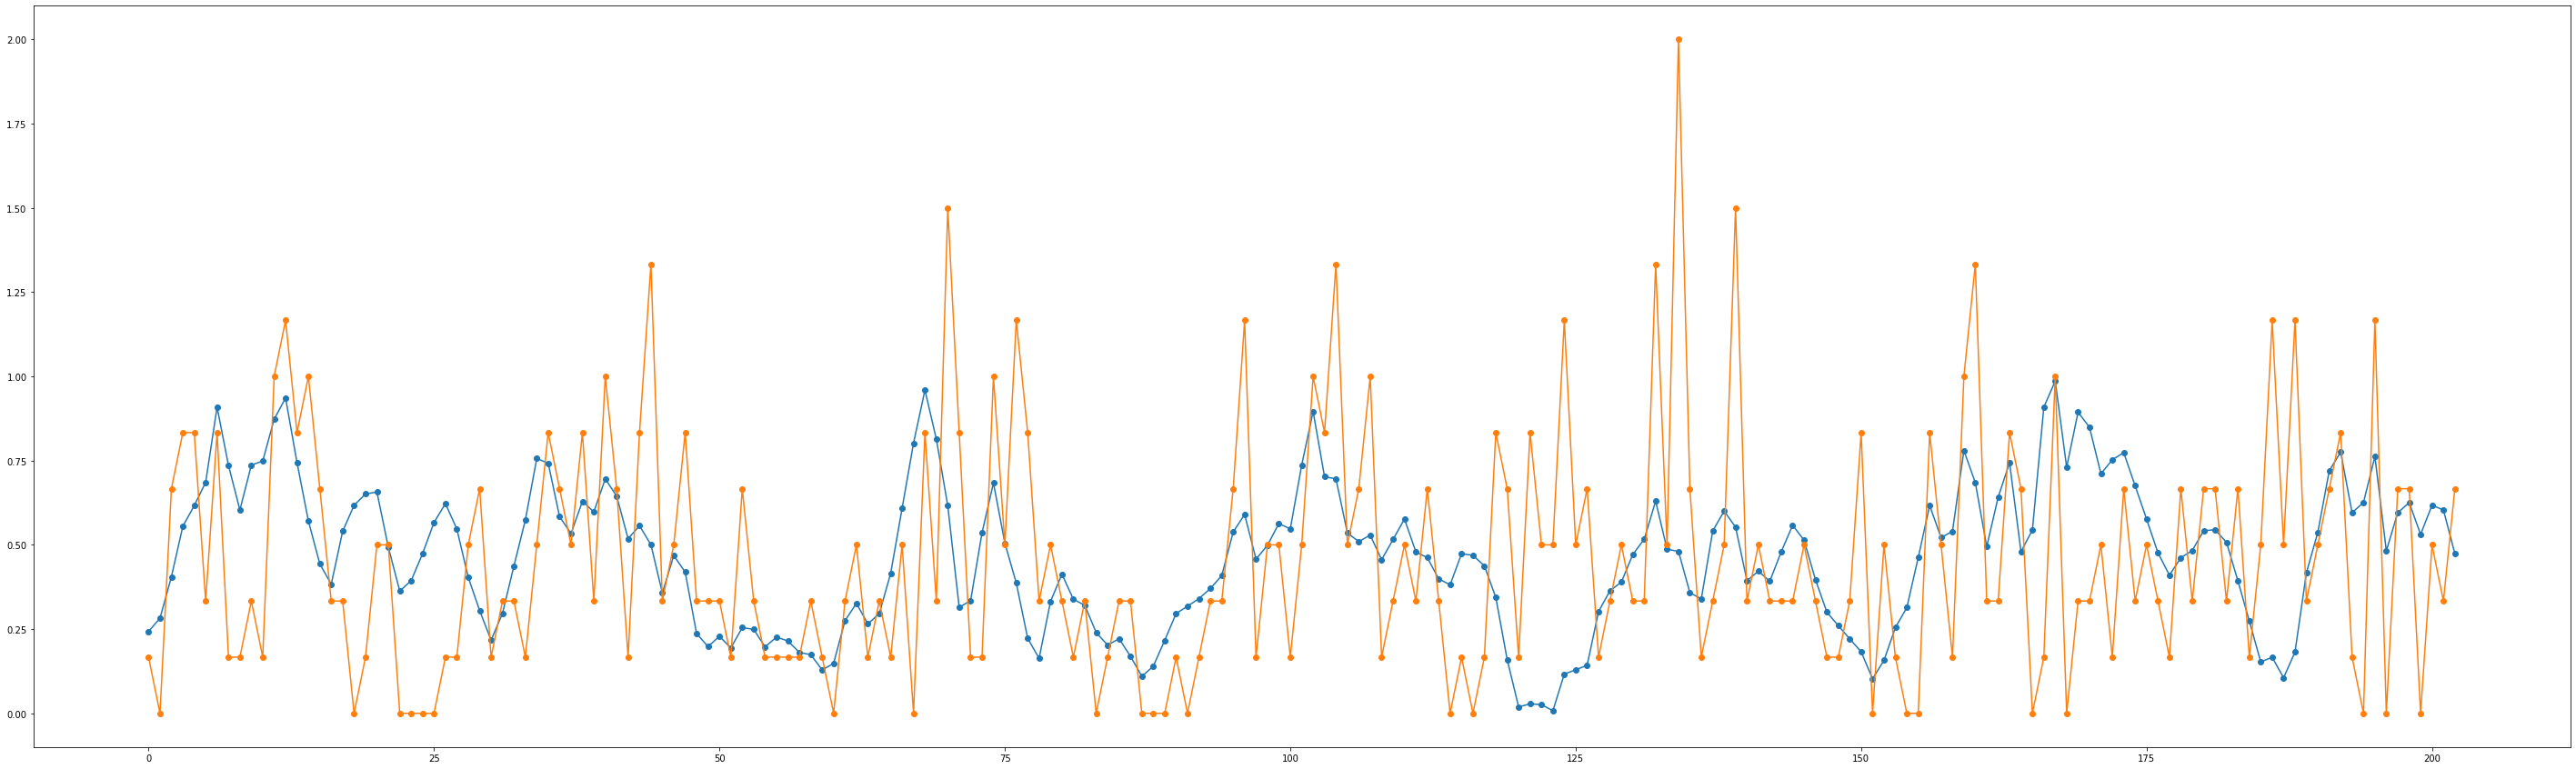

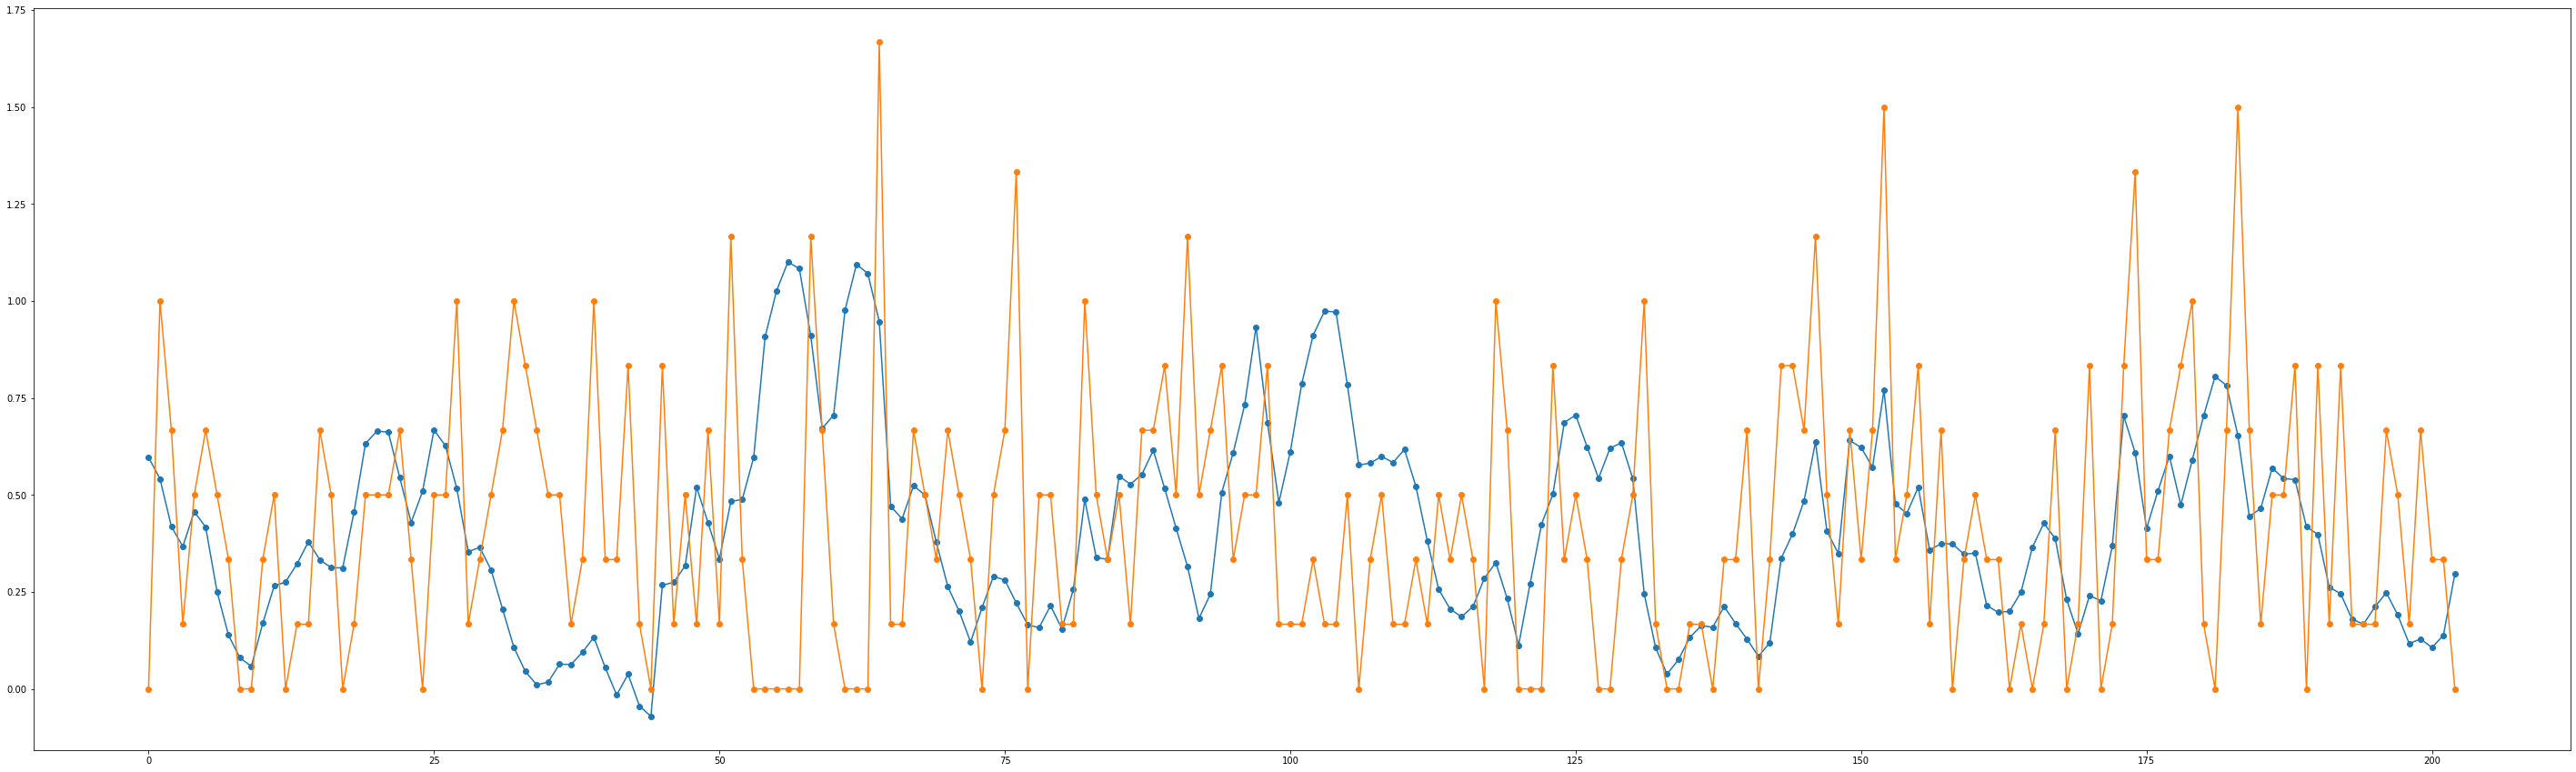

In [0]:
y_train_predict = regressor.predict(x_train)
y_val_predict = regressor.predict(x_val)
y_test_predict = regressor.predict(x_test)

plt.figure(figsize=(50,15))
plt.plot(y_train_predict[:,0],marker='o')
plt.plot(y_train[:,0],marker='o')
plt.title('Train')
plt.show()

plt.figure(figsize=(50,15))
plt.plot(y_val_predict[:,0],marker='o')
plt.plot(y_val[:,0],marker='o')

plt.figure(figsize=(50,15))
plt.plot(y_test_predict[:,0],marker='o')
plt.plot(y_test[:,0],marker='o')

## Most Relevant Features

In [0]:
corr = df_final.corr()

In [91]:
dataset = df_final.loc[:,corr[corr['qty_sales'].abs()>corr['qty_sales'].abs().mean()]['qty_sales'].index]
dataset

revenue_day  rolling_mean_revenue_2  ...  rolling_mean_sales_7  qty_sales
index                                        ...                                 
d_1            1.77                   0.000  ...              0.000000        1.0
d_2            3.54                   2.655  ...              0.000000        2.0
d_3            7.08                   5.310  ...              0.000000        4.0
d_4            3.54                   5.310  ...              0.000000        2.0
d_5            5.31                   4.425  ...              0.000000        3.0
...             ...                     ...  ...                   ...        ...
d_1909         1.98                   2.970  ...              2.857143        1.0
d_1910         3.96                   2.970  ...              2.571429        2.0
d_1911         7.92                   5.940  ...              2.714286        4.0
d_1912         3.96                   5.940  ...              2.857143        2.0
d_1913         0.00                   1.980  ...              2.285714        0.0

[1913 rows x 14 columns]

### Spliting Data

In [92]:
train_limit = int(round((dataset.shape[0])*0.7,0))
val_limit = int(round((dataset.shape[0])*0.85,0))

df_train = dataset[:train_limit]
df_val = dataset[train_limit:val_limit]
df_test = dataset[val_limit:]

print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

(1339, 14)
(287, 14)
(287, 14)


### Dealing with Outliers 

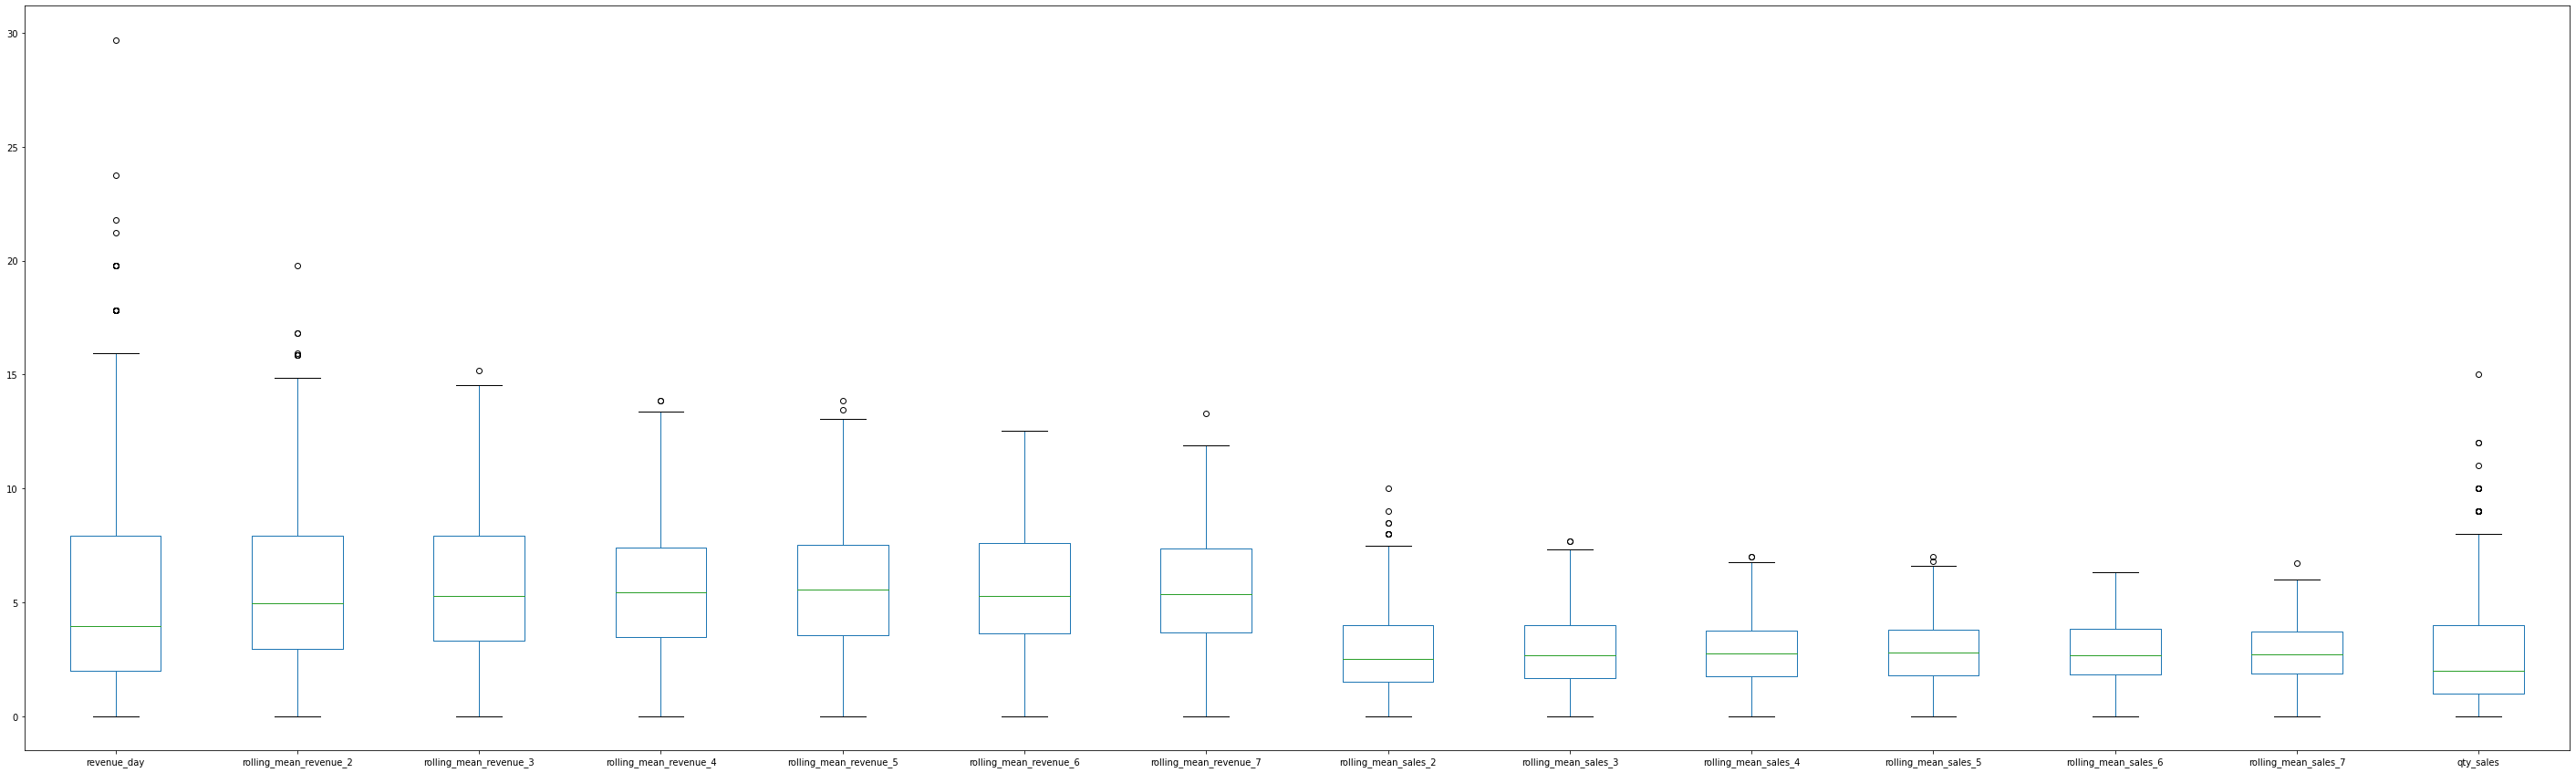

In [93]:
df_train.plot.box(figsize=(50,15))

In [94]:
for column in df_train.columns:
  try:
    df_train.loc[df_train[column]>df_train[column].quantile(0.9),column] = df_train[column].quantile(0.9)
  except:
    pass

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


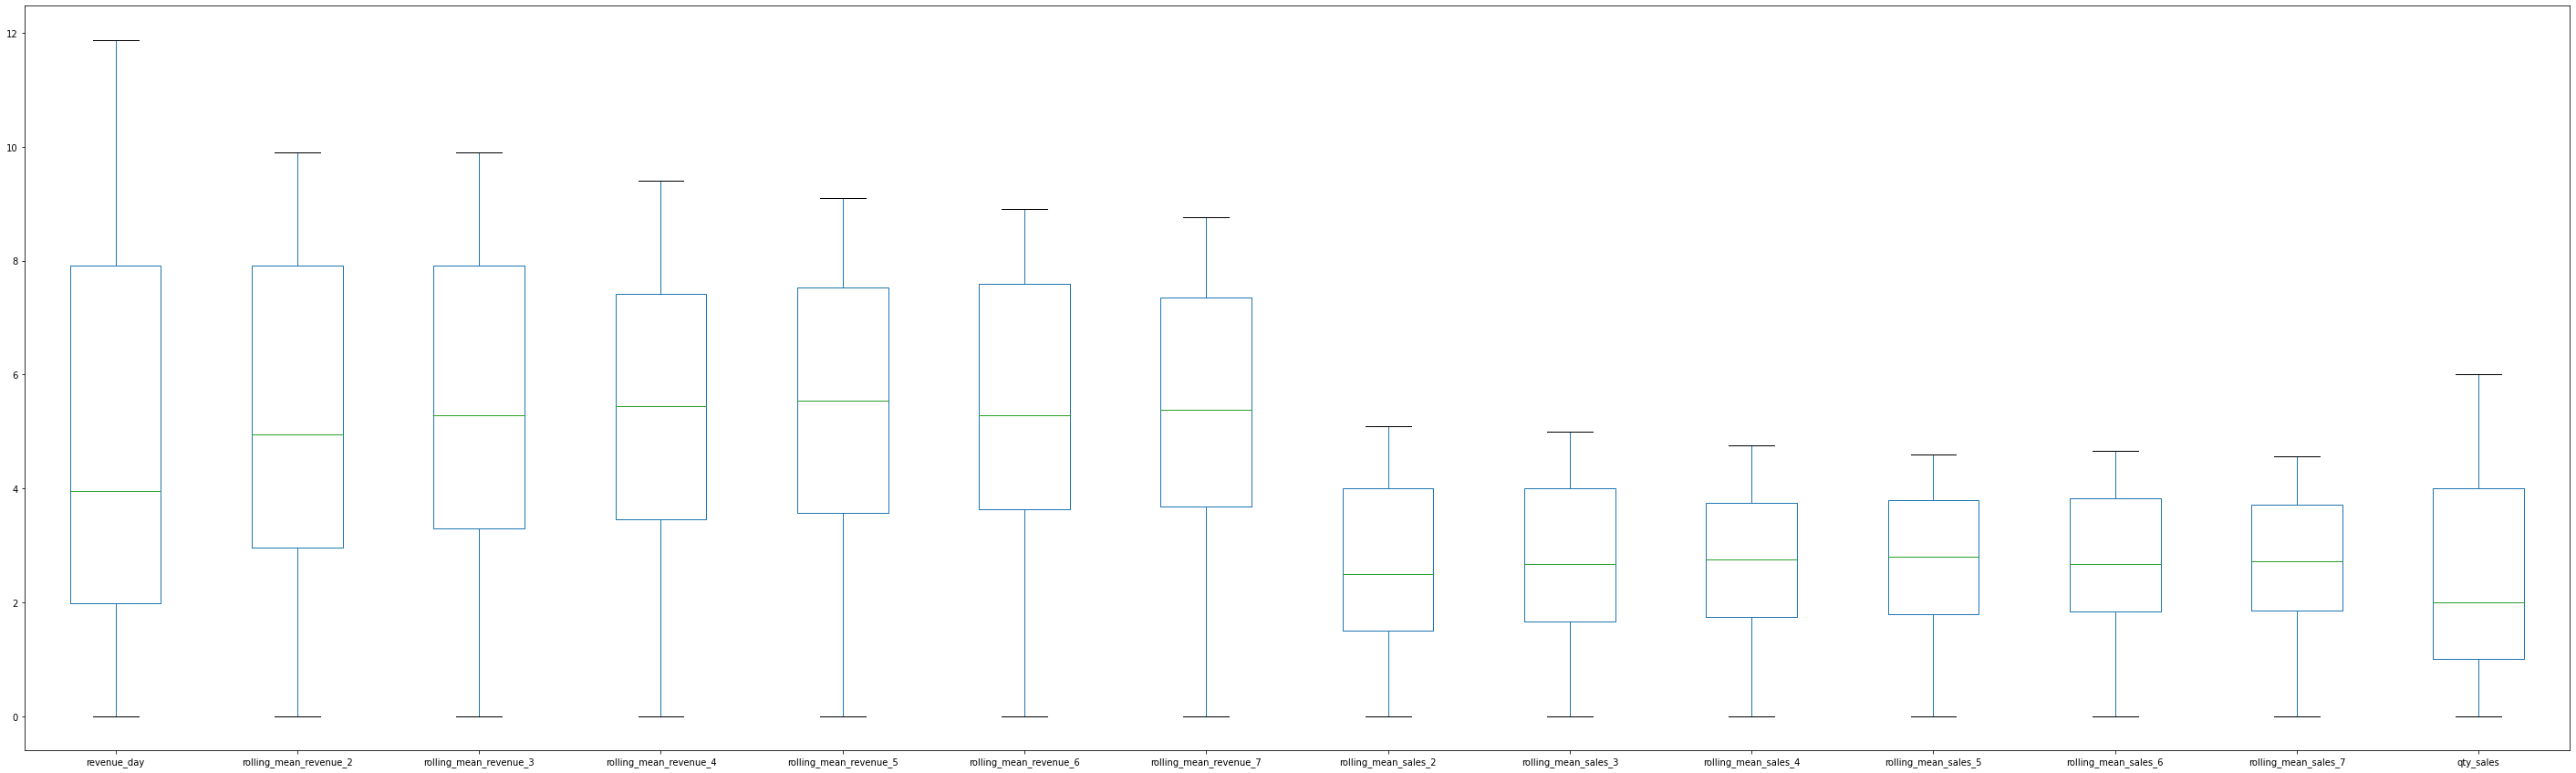

In [95]:
df_train.plot.box(figsize=(50,15))

### Normalizing

In [96]:
df_train_norm,df_val_norm,df_test_norm = normalizing_data(df_train,df_val,df_test)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


[2.         1.6        1.53333333 1.42105263 1.26086957 1.18518519
 1.12903226 1.56862745 1.53333333 1.42105263 1.26086957 1.14285714
 1.09375    2.        ]
[0.         0.         0.         0.         0.04347826 0.07407407
 0.12903226 0.         0.         0.         0.04347826 0.07142857
 0.125      0.        ]


[1.66666667 1.3        1.13333333 1.15789474 1.08695652 1.07407407
 1.03225806 1.2745098  1.13333333 1.15789474 1.08695652 1.03571429
 1.         1.66666667]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 5.65594514e-16 7.40740741e-02 1.61290323e-01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 7.14285714e-02
 1.56250000e-01 0.00000000e+00]
-------------------------
(1339, 14)
(287, 14)
(287, 14)


### Preprocessing

In [0]:
time_steps = 84
future_steps = 28
n_features = df_train_norm.shape[1]
x_train,x_test,x_val,y_train,y_val,y_test = Regressor(future_steps = future_steps,time_steps = time_steps,n_features = n_features,df_train = df_train_norm,df_val = df_val_norm,df_test = df_test_norm)

### LSTM

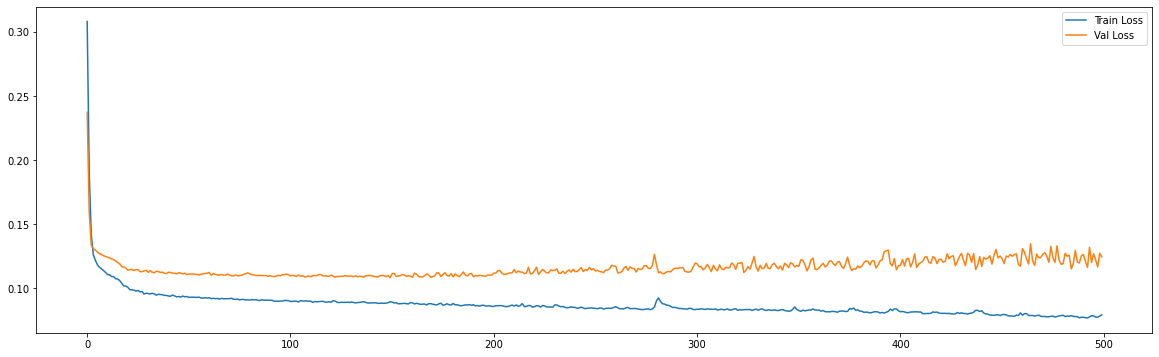

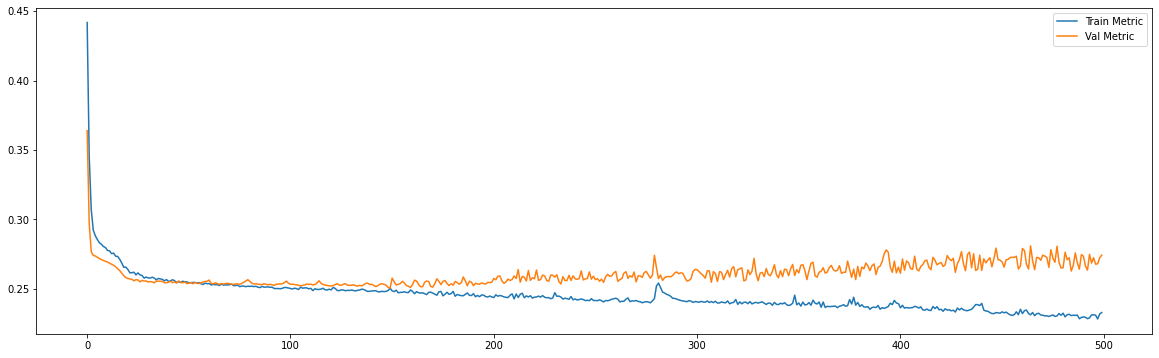



37/37 [==============================] - 0s 4ms/step - loss: 0.0776 - mae: 0.2320
loss and metric train data [0.07757266610860825, 0.23195694386959076]
7/7 [==============================] - 0s 4ms/step - loss: 0.1245 - mae: 0.2743
loss and metric val data [0.12449587136507034, 0.27432313561439514]
7/7 [==============================] - 0s 4ms/step - loss: 0.1391 - mae: 0.2970
loss and metric test data [0.13911280035972595, 0.29704272747039795]


In [102]:
regressor = Sequential()
regressor.add(LSTM(units=50, return_sequences=False, input_shape=(time_steps, n_features))) 
regressor.add(Dropout(0.2))
regressor.add(Dense(units=future_steps))

#Compiling the LSTM
adam = optimizers.Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999, decay = 0.0)
regressor.compile(optimizer = adam, loss = 'mse', metrics=['mae'])

#Fitting to traning set
history = regressor.fit(x_train, y_train, validation_data=(x_val,y_val), 
                        epochs = 500, batch_size=100, verbose = 0, shuffle= False)

plt.figure(figsize=(20,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train Loss', 'Val Loss'])

plt.figure(figsize=(20,6))
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.legend(['Train Metric', 'Val Metric'])
plt.show()

print('\n')
print('loss and metric train data',regressor.evaluate(x_train,y_train))
print('loss and metric val data',regressor.evaluate(x_val,y_val))
print('loss and metric test data',regressor.evaluate(x_test,y_test))

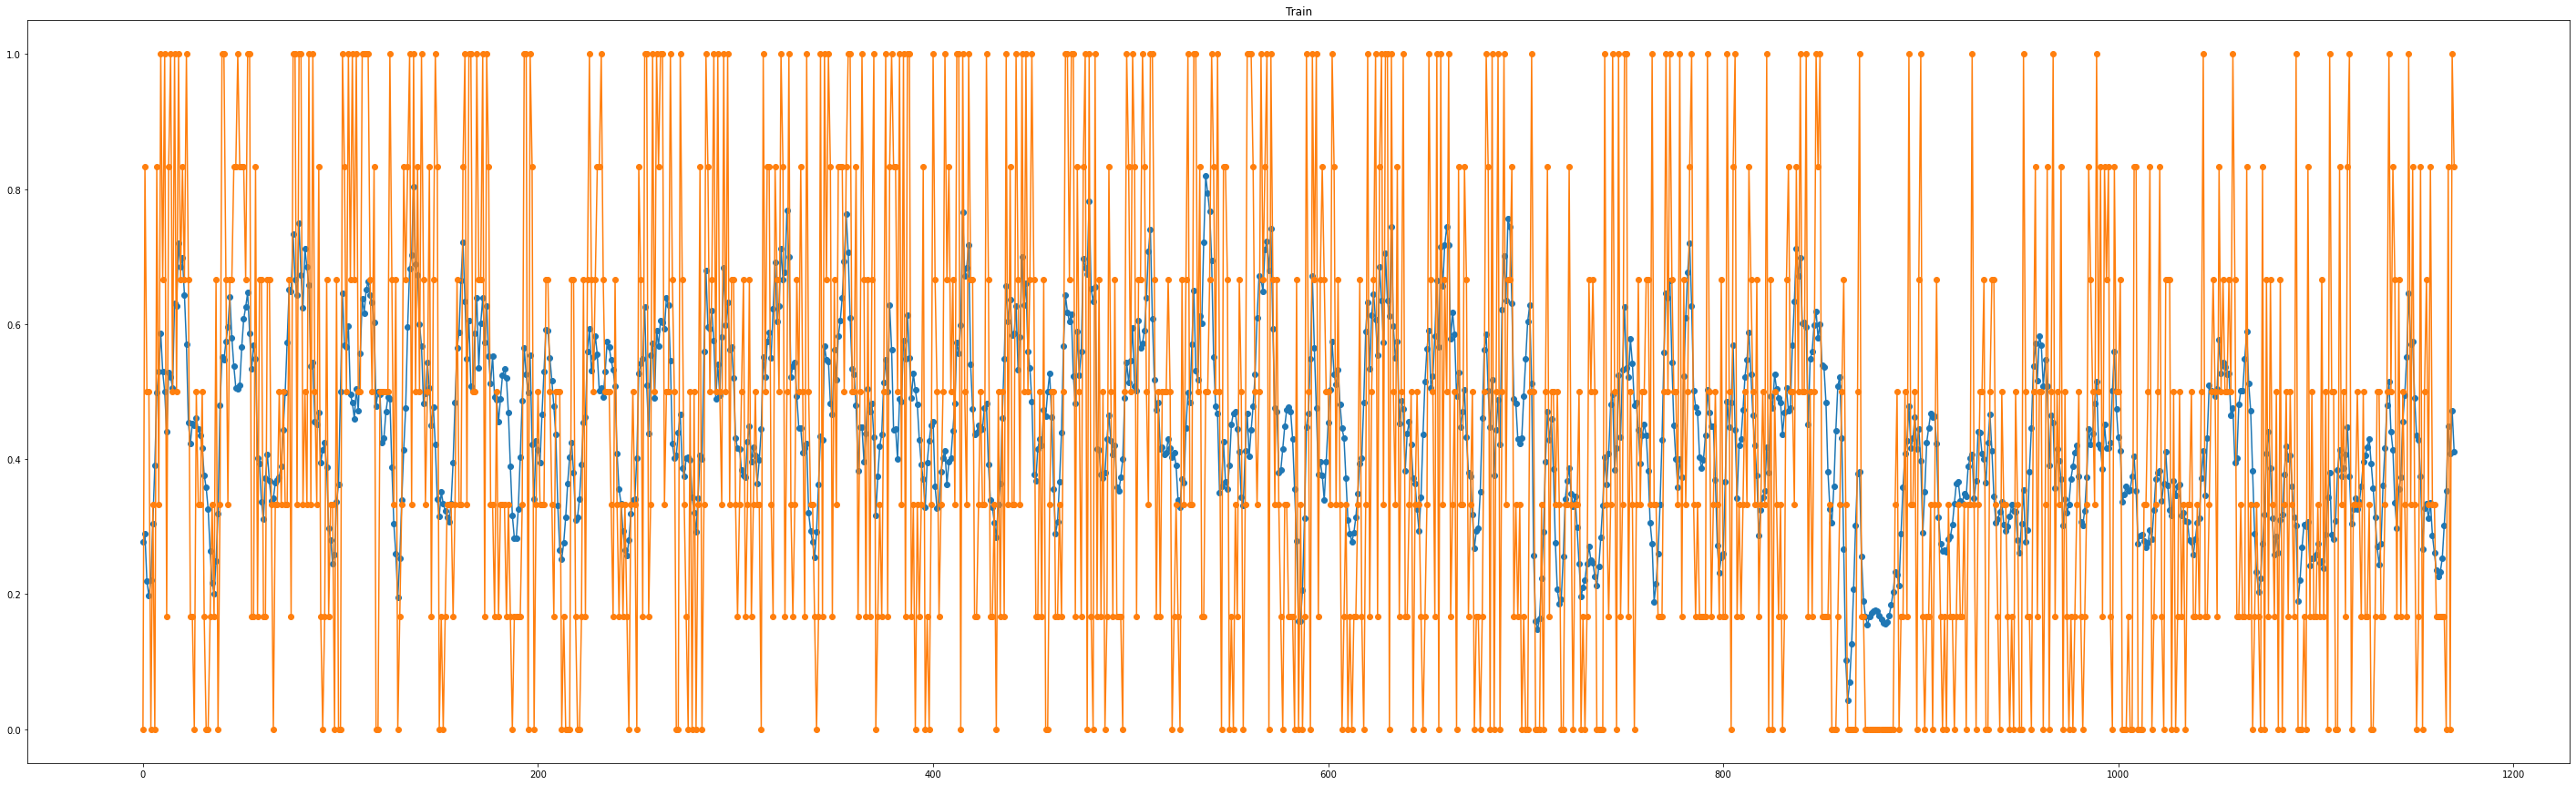

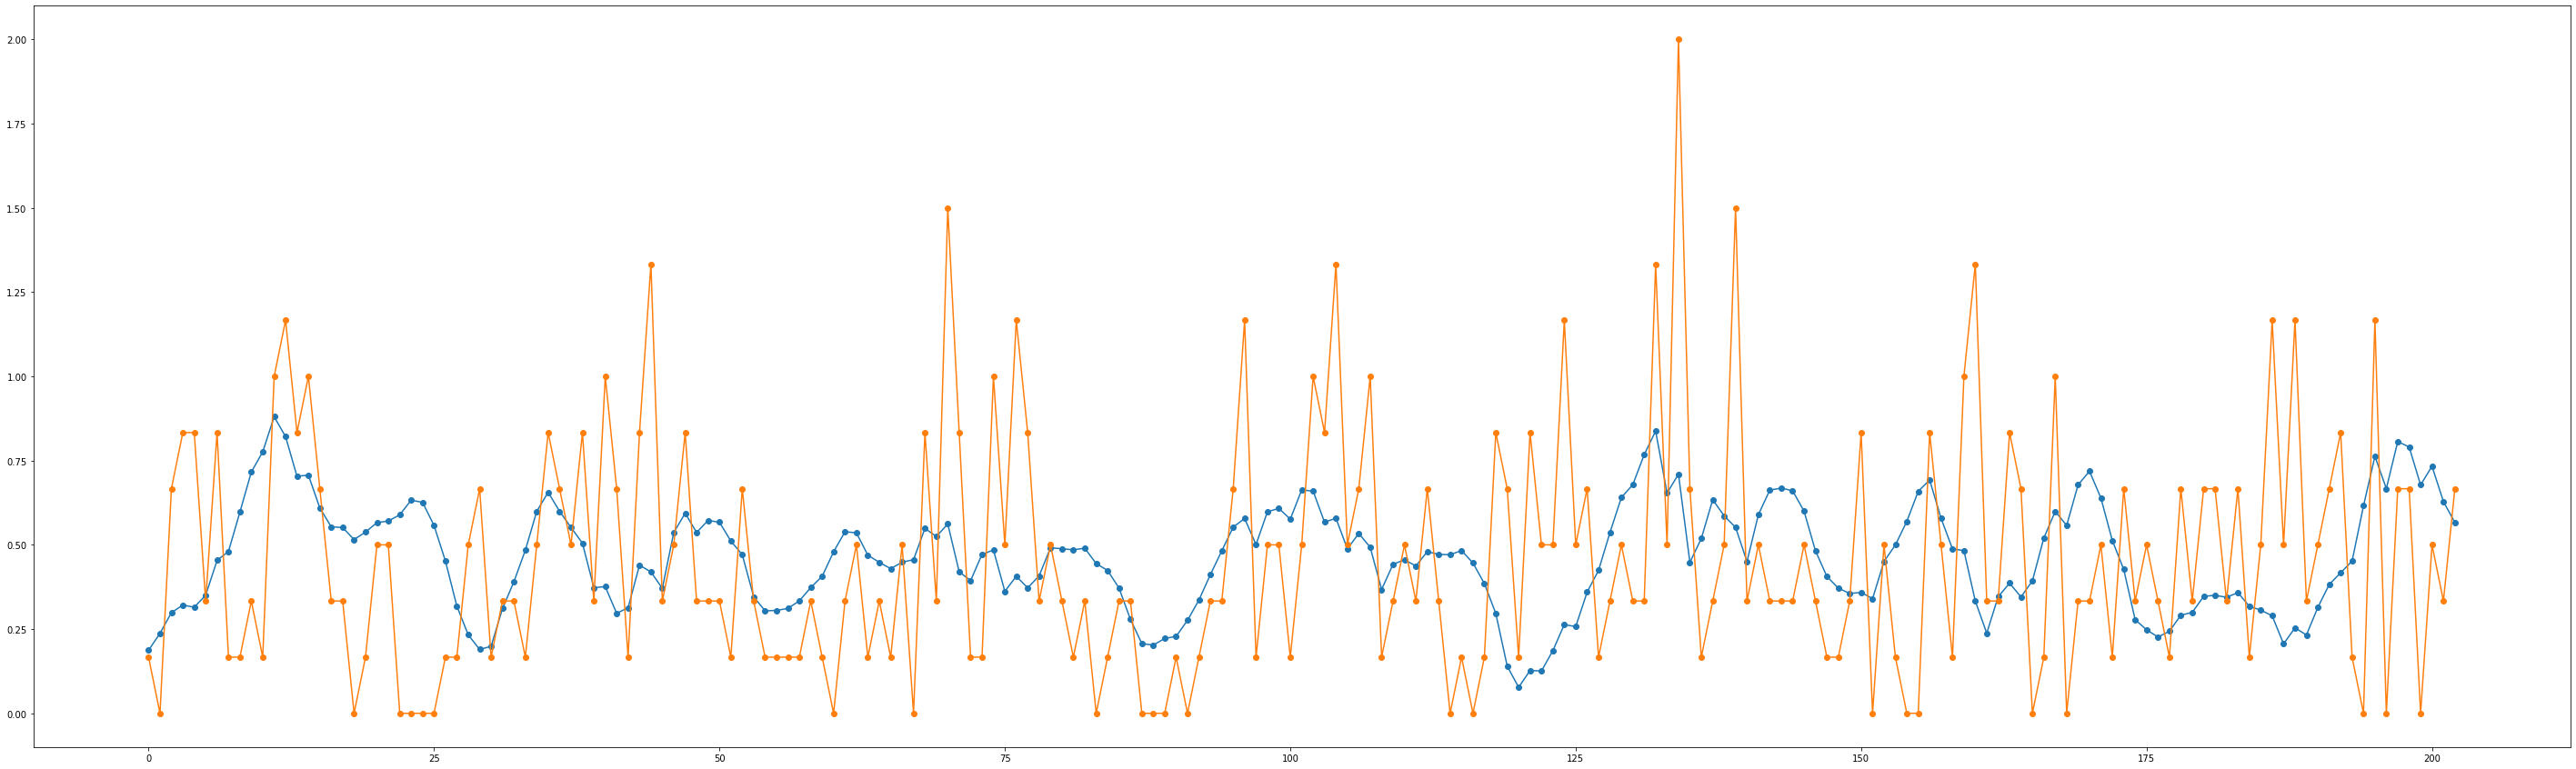

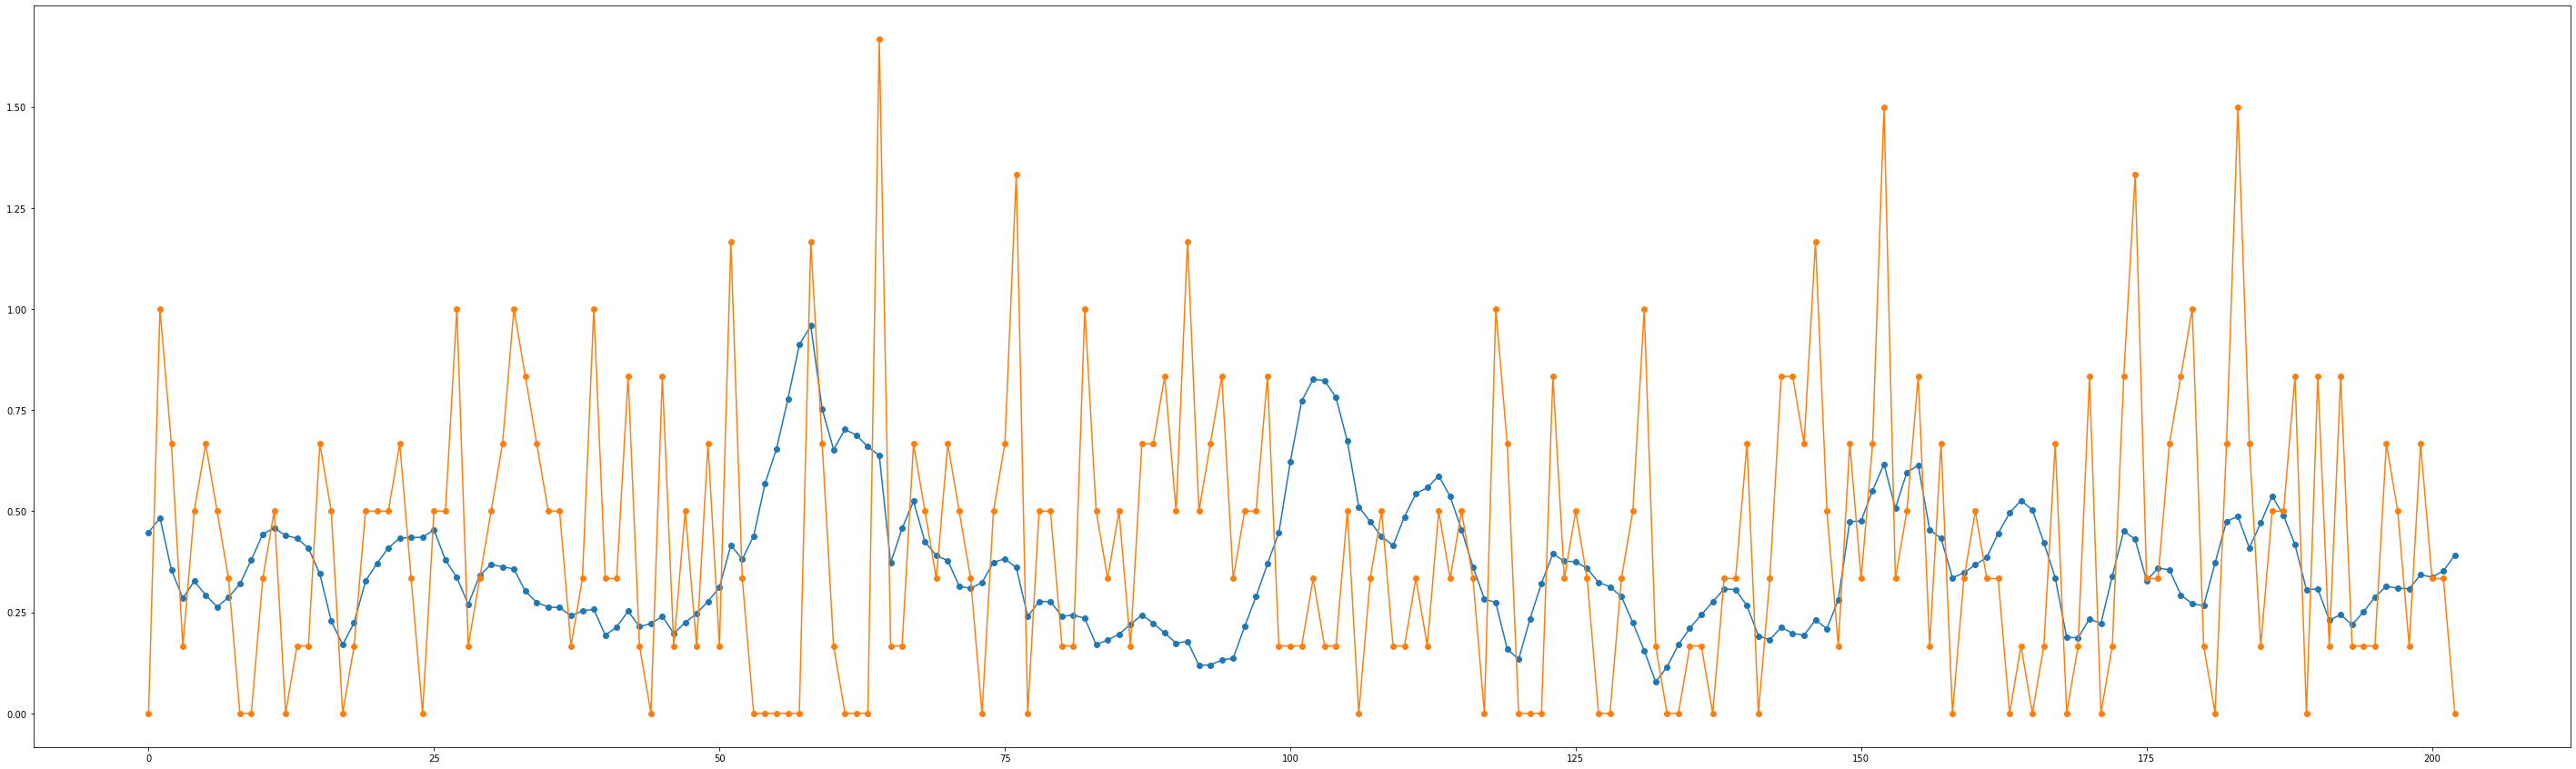

In [103]:
y_train_predict = regressor.predict(x_train)
y_val_predict = regressor.predict(x_val)
y_test_predict = regressor.predict(x_test)

plt.figure(figsize=(50,15))
plt.plot(y_train_predict[:,0],marker='o')
plt.plot(y_train[:,0],marker='o')
plt.title('Train')
plt.show()

plt.figure(figsize=(50,15))
plt.plot(y_val_predict[:,0],marker='o')
plt.plot(y_val[:,0],marker='o')

plt.figure(figsize=(50,15))
plt.plot(y_test_predict[:,0],marker='o')
plt.plot(y_test[:,0],marker='o')